# Setting up a basic ReAct Agent in LangGraph

In [1]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'
os.environ["SERPAPI_API_KEY"] = 's***'  # https://serpapi.com for a free token!

In [2]:
from langchain_community.utilities import SerpAPIWrapper
serpapi = SerpAPIWrapper()
serpapi.run('Sinan Ozdemir')

'[\'Sinan Ozdemir is a data scientist, start-up founder, and educator living in the San Francisco Bay Area. He studied pure mathematics at the Johns Hopkins University. ...\', \'Sinan Ozdemir type: Author.\', \'Sinan Ozdemir entity_type: people.\', \'Sinan Ozdemir main_tab_text: Overview.\', \'Sinan Ozdemir kgmid: /g/11hcjs9cr6.\', \'Specialized in areas including time management as well as mathematics and computer science logistics.\', \'AI Expert • Author • Entrepreneur. Helping companies leverage AI technology to solve complex problems. Founder, author, and consultant specializing in AI, LLMs, ...\', \'Data Scientist + Author + Entrepreneur. Check out my new book on LLMs on Amazon (Top 10 in AI/NLP). 612 followers · 3 following. LoopGenius.\', "A beginner\'s guide to essential math and coding skills for data fluency and machine learning by Sinan Ozdemir", \'Sinan Ozdemir is a mathematician, data scientist, NLP expert, lecturer, and accomplished author. He is currently applying my ex

In [3]:
# alternative way to get a tool from langchain

from langchain_community.agent_toolkits.load_tools import load_tools
tools = load_tools(["serpapi"])

In [4]:
tools[0].run('sinan ozdemir')

'[\'Sinan Ozdemir is a data scientist, start-up founder, and educator living in the San Francisco Bay Area. He studied pure mathematics at the Johns Hopkins University. ...\', \'Sinan Ozdemir type: Author.\', \'Sinan Ozdemir entity_type: people.\', \'Sinan Ozdemir kgmid: /g/11hcjs9cr6.\', \'Specialized in areas including time management as well as mathematics and computer science logistics.\', \'AI Expert • Author • Entrepreneur. Helping companies leverage AI technology to solve complex problems. Founder, author, and consultant specializing in AI, LLMs, ...\', \'Data Scientist + Author + Entrepreneur. Check out my new book on LLMs on Amazon (Top 10 in AI/NLP). 612 followers · 3 following. LoopGenius.\', "A beginner\'s guide to essential math and coding skills for data fluency and machine learning by Sinan Ozdemir", \'Sinan Ozdemir is a mathematician, data scientist, NLP expert, lecturer, and accomplished author. He is currently applying my extensive knowledge and ...\', \'NLP + Gen AI 

In [5]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini")
agent_executor = create_react_agent(llm, tools, state_modifier='Today is May 30th, 2025')  # true as of 5/30/2025 ;)

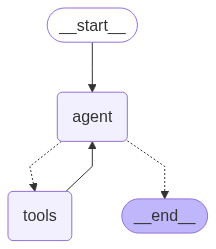

In [6]:
# Compile the graph
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

# Turn our ReAct Agent into a Chat

In [7]:
from langgraph.graph import MessagesState, StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage

In [26]:
def turn_react_agent_into_chat(agent_executor):
    
    class ConvoState(MessagesState):
        # MessagesState already has messages in it
        end: bool
    
    def get_user_input(state):
        user_msg = input("\n🧑 You: ")
        if user_msg.strip().lower() == "exit":
            return {'end': True}
        return {"messages": HumanMessage(content=user_msg)}
    
    def run_agent(state):
        response = agent_executor.invoke({"messages": state["messages"]})
        print(f"\n🤖 Agent: {response['messages'][-1].content}")
        return {"messages": AIMessage(content=response['messages'][-1].content)}
    
    graph_builder = StateGraph(ConvoState)
    graph_builder.add_node("get_user_input", get_user_input)
    graph_builder.add_node("run_agent", run_agent)
    
    graph_builder.set_entry_point("get_user_input")
    graph_builder.add_conditional_edges(
        "get_user_input", 
        lambda state: 'end' if state.get('end') else 'go',
        {
            'end': END,
            'go': 'run_agent'
        }
    )
    graph_builder.add_edge("run_agent", "get_user_input")
    
    graph = graph_builder.compile()
    return graph

In [27]:
graph = turn_react_agent_into_chat(agent_executor)
print("💬 Start chatting with the agent! Type 'exit' to stop.")
graph.invoke({"messages": []})

💬 Start chatting with the agent! Type 'exit' to stop.



🧑 You:  hi



🤖 Agent: Hello! How can I assist you today?



🧑 You:  I'm Sinan



🤖 Agent: Nice to meet you, Sinan! How can I help you today?



🧑 You:  what's my name?



🤖 Agent: Your name is Sinan. How can I assist you further?



🧑 You:  What's the weather in SF?



🤖 Agent: The current weather in San Francisco is sunny with a temperature of 54°F. There is 0% chance of precipitation, humidity is at 92%, and the wind is blowing at 5 mph. If you need more information, feel free to ask!



🧑 You:  and today's date?



🤖 Agent: Today's date is May 30, 2025. If you have any other questions or need assistance with something else, just let me know!



🧑 You:  exit


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='b77fdb39-d4df-494d-a33d-943472df2a30'),
  AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={}, id='26bcb393-7931-4a3a-8af4-9a35a322035f'),
  HumanMessage(content="I'm Sinan", additional_kwargs={}, response_metadata={}, id='552d6223-87ae-4320-a576-e1cc146bcd3a'),
  AIMessage(content='Nice to meet you, Sinan! How can I help you today?', additional_kwargs={}, response_metadata={}, id='64fc7878-3433-42d5-a654-8a506502516b'),
  HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='e0c9a66d-b4ee-432e-ad0a-e625facff1d1'),
  AIMessage(content='Your name is Sinan. How can I assist you further?', additional_kwargs={}, response_metadata={}, id='6aea95a4-9210-46eb-81f5-2969450392eb'),
  HumanMessage(content="What's the weather in SF?", additional_kwargs={}, response_metadata={}, id='ab7507c4-9f7b-4f3a-93de-f2ad96599ad7'),
  AIMess

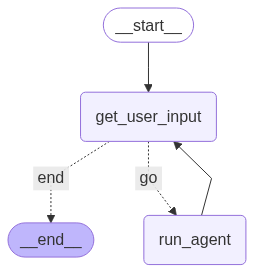

In [28]:
# Compile the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Bringing MCP into the mix

In [8]:
# Import necessary libraries
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.tools import load_mcp_tools
from langgraph.prebuilt import create_react_agent
import nest_asyncio

# Apply nest_asyncio to handle nested event loops
nest_asyncio.apply()

In [46]:
import os

# Note this is NOT an production ready MCP server, don't include env variables this way. 
#  I'm doing this so I can work in a notebook
MCP_SERVER = f'''
from mcp.server.fastmcp import FastMCP
from langchain_community.utilities import SerpAPIWrapper
import os

mcp = FastMCP("MCP Example")

@mcp.tool()
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

@mcp.tool()
def multiply(a: int, b: int) -> int:
    """Multiply two numbers"""
    return a * b

@mcp.tool()
def google_something(query: str) -> str:
    """Online Realtime Web Search"""
    serpapi = SerpAPIWrapper(serpapi_api_key="{os.getenv("SERPAPI_API_KEY")}")
    return serpapi.run(query)

if __name__ == "__main__":
    mcp.run(transport="stdio")
'''

mcp_path = 'mcp_server.py'

with open(mcp_path, 'w') as f:
    f.write(MCP_SERVER)

print("Saved to:", os.path.abspath(mcp_path))


Saved to: /Users/sinanozdemir/Teaching/Pearson/oreilly-ai-agents/notebooks/mcp_server.py


In [47]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

server_params = StdioServerParameters(
    command="python",
    args=[os.path.abspath(mcp_path)]
)

async def agent_run_async(m):
    async with stdio_client(server_params) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            mcp_tools = await load_mcp_tools(session)
            for tool in mcp_tools:
                print(f'Tool Name: {tool.name}')
                print(f'Tool Description: {tool.description}')
                print(f'Tool Args Schema: {tool.args_schema}')
                print(f'Tool Args : {tool.response_format}')
                print('------')
            agent = create_react_agent(llm, mcp_tools)
            response = await agent.ainvoke({"messages": m})
            return response

agent_response = await agent_run_async("what's the current price of bitcoin times 12?")

Tool Name: add
Tool Description: Add two numbers
Tool Args Schema: {'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'addArguments', 'type': 'object'}
Tool Args : content_and_artifact
------
Tool Name: multiply
Tool Description: Multiply two numbers
Tool Args Schema: {'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'title': 'multiplyArguments', 'type': 'object'}
Tool Args : content_and_artifact
------
Tool Name: google_something
Tool Description: Online Realtime Web Search
Tool Args Schema: {'properties': {'query': {'title': 'Query', 'type': 'string'}}, 'required': ['query'], 'title': 'google_somethingArguments', 'type': 'object'}
Tool Args : content_and_artifact
------


In [48]:
agent_response['messages'][-1]

AIMessage(content='The current price of Bitcoin is $105,558. When multiplied by 12, the result is $1,266,696.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 157, 'total_tokens': 185, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BcuECzEZkLGCciLKz67dPGcSKHjGs', 'finish_reason': 'stop', 'logprobs': None}, id='run-967fe74e-bc88-4557-932a-78269f4c35bb-0', usage_metadata={'input_tokens': 157, 'output_tokens': 28, 'total_tokens': 185, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [49]:
for message in agent_response['messages']:
    print(type(message), message.content, 'Tool ID:' + message.tool_call_id if hasattr(message, 'tool_call_id') else '')
    if message.additional_kwargs.get('tool_calls'):
        for tool_call in message.additional_kwargs.get('tool_calls'):
            print(f'Tool Call: ID({tool_call["id"]}), Name({tool_call["function"]["name"]}), Args({tool_call["function"]["arguments"]})')
    print('----')

<class 'langchain_core.messages.human.HumanMessage'> what's the current price of bitcoin times 12? 
----
<class 'langchain_core.messages.ai.AIMessage'>  
Tool Call: ID(call_LofY29fqPTRc2vAannpTts4x), Name(google_something), Args({"query":"current price of bitcoin"})
----
<class 'langchain_core.messages.tool.ToolMessage'> 105,558.00 Tool ID:call_LofY29fqPTRc2vAannpTts4x
----
<class 'langchain_core.messages.ai.AIMessage'>  
Tool Call: ID(call_2l3qIjpsiTCre24ZheOGEDbA), Name(multiply), Args({"a":105558,"b":12})
----
<class 'langchain_core.messages.tool.ToolMessage'> 1266696 Tool ID:call_2l3qIjpsiTCre24ZheOGEDbA
----
<class 'langchain_core.messages.ai.AIMessage'> The current price of Bitcoin is $105,558. When multiplied by 12, the result is $1,266,696. 
----


In [50]:
len(agent_response['messages'])

6

# Testing for Accuracy + Positional Bias

In [4]:
tool_selection_test_data = [
    ('What is the price of ethereum right now?', 'crypto_and_nft_tool'),
    ('What is the price of bitcoin right now?', 'crypto_and_nft_tool'),
    ('Check the floor price of the world of women nft', 'crypto_and_nft_tool'),

    ('Add a new row and just write "To do" in it', 'google_spreadsheet_tool'),
    ('Add this data to the spreadsheet: "1, 2, 3"', 'google_spreadsheet_tool'),
    ('Add: "Sinan, LoopGenius" to the spreadsheet', 'google_spreadsheet_tool'),

    ('Go to https://loopgenius.com and tell me about it', 'firecrawl_tool'),
    ('Visit https://github.com/trending and list top repositories', 'firecrawl_tool'),
    ('Scrape the main headlines from https://news.ycombinator.com', 'firecrawl_tool'),
    ('Go to https://en.wikipedia.org/wiki/Python_(programming_language) and summarize the introduction', 'firecrawl_tool'),
    ('Check the documentation at https://pytorch.org and tell me the latest version name', 'firecrawl_tool'),
    ('Visit https://openai.com and summarize the homepage', 'firecrawl_tool'),
    ('What is the headline on https://bbc.com/news', 'firecrawl_tool'),

    ('What are the current gas prices in Chicago?', 'serp_tool'),
    ('What is the weather in San Francisco?', 'serp_tool'),
    ('Find the intro.co link for Sinan Ozdemir', 'serp_tool'),
    ('What is the release date of the next Marvel movie?', 'serp_tool'),
    ('Who won the latest Super Bowl?', 'serp_tool'),
    ('What are the top restaurants in New York City?', 'serp_tool'),
    ('Get the latest stock price for Apple (AAPL)', 'serp_tool'),
    ('List the top 5 popular programming languages in 2024', 'serp_tool'),
    ('Look up the conversion from 98 degrees Fahrenheit to Celsius on the web', 'serp_tool'),

    ('Convert 98 degrees Fahrenheit to Celsius using Python', 'python_repl_tool'),
    ('Write a function that yields the nth fibonacci number and use it to find the 100th fibonacci number', 'python_repl_tool'),
    ('Calculate the factorial of 10 using Python', 'python_repl_tool'),
    ('Calculate 15% of 34543.453', 'python_repl_tool'),
    ('Convert 42 kilometers to miles using a function in Python', 'python_repl_tool'),
    ('Generate a random number between 1 and 1000', 'python_repl_tool'),
]


In [5]:
import os
import random

# Define tool snippets
tool_snippets = [
    '''
@mcp.tool()
def google_spreadsheet_tool(action: str = "append_to_sheet", **kwargs) -> dict:
    """
    Executes specified actions on the Google Spreadsheet.

    :param action: The action to perform ("append_to_sheet", "search", "insert_into_cell", "get_data_in_range", "describe").
    :Additional arguments for each specific action:
        - "search": 
            "search" will return the row indices where the search_value is found in the column_name.
            Requires 'search_value' and 'column_name'. Example: {"action": "search", "search_value": "John", "column_name": "Name"}
        - "append_to_sheet":
            "append_to_sheet" will append the data to the end of the sheet.
            Requires 'data'. Example: {"action": "append_to_sheet", "data": [["John", "Doe", "john.doe@example.com"], ["Jane", "Smith", "jane.smith@example.com"]]}
        - "insert_into_cell": 
            "insert_into_cell" will insert the value into the specified cell.
            Requires 'value' and 'cell'. Example: {"action": "insert_into_cell", "value": "New Value", "cell": "A1"}
        - "get_data_in_range": 
            "get_data_in_range" will return the data in the specified range.
            Requires 'range_name'. Example: {"action": "get_data_in_range", "range_name": "Sheet1!A1:B2"} or {"action": "get_data_in_range",    "range_name": "Contacts!A12:G28"}
        - "describe": 
            "describe" will return the number of columns and rows in the sheet.
            No additional arguments. Example: {"action": "describe"}
    :return: The result of the operation.
    """
''',
    '''
@mcp.tool()
def crypto_and_nft_tool(query: str) -> str:
    """Get current cryptocurrency prices and NFT prices around the world and for a specific wallet."""
    return f"Fake response for crypto/NFT query: {query}"
''',
    '''
@mcp.tool()
def firecrawl_tool(website_url: str) -> str:
    """
    Crawl webpages and return a markdown version of the html on the page
    :param website_url: The URL of the website to scrape
    """
    return f"Scraped data from: {website_url}"
''',
    '''
@mcp.tool()
def serp_tool(query: str) -> str:
    """Search the web for information using the Google Search Engine"""
    return f"Search result for query: {query}"
''',
    '''
@mcp.tool()
def python_repl_tool(code: str) -> str:
    """
    Execute valid python code and returns the printed values in the code
    :param command: The Python command to run. Always end with a print statement to show the output like "print(output)"
    """
    try:
        result = eval(code)
        return str(result)
    except Exception as e:
        return f"Error: {e}"
'''
]

def generate_random_mcp_order(mcp_path='random_mcp_server.py'):
    # Shuffle tool definitions
    random.shuffle(tool_snippets)
    
    # Create full server code
    MCP_SERVER = f'''
from mcp.server.fastmcp import FastMCP
from langchain_community.tools import DuckDuckGoSearchRun

mcp = FastMCP("MCP Example")
{''.join(tool_snippets)}

if __name__ == "__main__":
    mcp.run(transport="stdio")
    '''
    
    # Save to file
    with open(mcp_path, 'w') as f:
        f.write(MCP_SERVER)
    
    return os.path.abspath(mcp_path), [t.split('def')[-1].split('(')[0].strip() for t in tool_snippets]
random_mcp, tools = generate_random_mcp_order()

print(f"Saved to: {random_mcp}\nTool order: {tools}")

Saved to: /Users/sinanozdemir/Teaching/Pearson/oreilly-ai-agents/notebooks/random_mcp_server.py
Tool order: ['firecrawl_tool', 'crypto_and_nft_tool', 'python_repl_tool', 'google_spreadsheet_tool', 'serp_tool']


In [6]:
import json
tools

['firecrawl_tool',
 'crypto_and_nft_tool',
 'python_repl_tool',
 'google_spreadsheet_tool',
 'serp_tool']

In [31]:
from langchain_core.messages.human import HumanMessage

async def tool_use_run(llm, initial_message):
    random_mcp_path, mcp_tool_order = generate_random_mcp_order()
    server_params = StdioServerParameters(command="python", args=[random_mcp_path])
    
    async with stdio_client(server_params) as (read, write):
        async with ClientSession(read, write) as session:
            await session.initialize()
            tools = await load_mcp_tools(session)
            ai_message = llm.bind_tools(tools).invoke([HumanMessage(content=initial_message)])
            tools_used = []
            if type(ai_message.content) == list:
                for c in ai_message.content:  # anthropic
                    if c['type'] == 'tool_use':
                        tools_used.append((c['name'], c['input']))
            if hasattr(ai_message, 'additional_kwargs') and 'tool_calls' in ai_message.additional_kwargs:  # openai
                for tc in ai_message.additional_kwargs['tool_calls']:
                    tools_used.append((tc['function']['name'], tc['function']['arguments']))
            return ai_message, tools_used, mcp_tool_order

In [20]:
llm = ChatAnthropic(model_name='claude-3-7-sonnet-latest', temperature=1)
await tool_use_run(llm, 'look up Sinan Ozdemir')

(AIMessage(content=[{'text': "I'll look up information about Sinan Ozdemir for you. Let me search the web to find relevant details about him.", 'type': 'text'}, {'id': 'toolu_01TuDqK8m3R3B9kmefqEqUQQ', 'input': {'query': 'Sinan Ozdemir'}, 'name': 'serp_tool', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_019EqXoKQ9dAyh9ExDwqxcsy', 'model': 'claude-3-7-sonnet-20250219', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 1200, 'output_tokens': 89}, 'model_name': 'claude-3-7-sonnet-20250219'}, id='run-2e9093a6-b6c8-44ec-8e95-9147a69e675e-0', tool_calls=[{'name': 'serp_tool', 'args': {'query': 'Sinan Ozdemir'}, 'id': 'toolu_01TuDqK8m3R3B9kmefqEqUQQ', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1200, 'output_tokens': 89, 'total_tokens': 1289, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}}),
 [('serp_tool', {'query': 'Sinan Ozdemir'})],
 ['serp_tool'

In [21]:
llm = ChatOpenAI(model="openrouter/optimus-alpha", temperature=1, base_url="https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"])
await tool_use_run(llm, 'look up Sinan Ozdemir')

(AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_feKEKn9WbM3NY7rejZittspf', 'function': {'arguments': '{"query":"Sinan Ozdemir"}', 'name': 'serp_tool'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 561, 'total_tokens': 581, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'openrouter/optimus-alpha', 'system_fingerprint': None, 'id': 'gen-1744502088-fbrnvbMTGQXCzA0s9Poj', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-04a4a9b4-8f9c-48f3-94de-fe0a5bd8943d-0', tool_calls=[{'name': 'serp_tool', 'args': {'query': 'Sinan Ozdemir'}, 'id': 'call_feKEKn9WbM3NY7rejZittspf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 561, 'output_tokens': 20, 'total_tokens': 581, 'input_token_details': {'cac

In [85]:
llm = ChatOpenAI(model="google/gemini-2.0-flash-001", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"])

await tool_use_run(llm, 'Add a new row and just write "To do" in it')

(AIMessage(content='Could you please specify which Google Sheet you would like to append the data to? I need the spreadsheet name to proceed.\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 572, 'total_tokens': 597, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-1744732968-EPozMpGZWhsWO8WXtigQ', 'finish_reason': 'stop', 'logprobs': None}, id='run-64462521-23cf-4efc-ac37-4133f5adff85-0', usage_metadata={'input_tokens': 572, 'output_tokens': 25, 'total_tokens': 597, 'input_token_details': {}, 'output_token_details': {}}),
 [],
 ['google_spreadsheet_tool',
  'python_repl_tool',
  'serp_tool',
  'firecrawl_tool',
  'crypto_and_nft_tool'])

In [22]:
results = []
errors = []

In [97]:
llms = [
            ChatOpenAI(model="gpt-4o-mini", temperature=1),
            ChatOpenAI(model="gpt-4o", temperature=1),
        
            ChatAnthropic(model_name='claude-3-5-haiku-latest', temperature=1),
            ChatAnthropic(model_name='claude-3-7-sonnet-latest', temperature=1),
        
            ChatOpenAI(model="openrouter/optimus-alpha", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            
            ChatOpenAI(model="google/gemini-2.0-flash-001", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            
            ChatOpenAI(model="deepseek/deepseek-chat-v3-0324", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            
            ChatOpenAI(model="meta-llama/llama-4-maverick", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            ChatOpenAI(model="meta-llama/llama-4-scout", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            ChatOpenAI(model="meta-llama/llama-3.3-70b-instruct", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            
            ChatOpenAI(model="x-ai/grok-3-beta", temperature=1, base_url= "https://openrouter.ai/api/v1", api_key=os.environ["OPENROUTER_API_KEY"]),
            ChatOpenAI(model="gpt-4.1", temperature=1),
            ChatOpenAI(model="gpt-4.1-mini", temperature=1)
        ]

In [120]:
from tqdm import tqdm
from random import sample
import pandas as pd
from langchain_anthropic import ChatAnthropic
n = 10
import time

for initial_message, expected_tool in tqdm(tool_selection_test_data):
    for llm in llms:
        for _ in range(n):
            try:
                response, tools_used, mcp_tool_order = await tool_use_run(llm, initial_message)
                first_tool_used_by_agent = tools_used[0][0] if tools_used else None
                time.sleep(0.3)
            except Exception as e:
                errors.append(f'error: {e} on llm: {llm}')
            results.append(
                {
                    'llm': llm.model_name if hasattr(llm, 'model_name') else llm.model,
                    'initial_message': initial_message,
                    'first_tool_used_by_agent': first_tool_used_by_agent,
                    'tools_used_by_agent': tools_used, 
                    'mcp_tool_order': mcp_tool_order, 
                    'expected_tool': expected_tool,
                    'correct_tool_index': mcp_tool_order.index(expected_tool),
                    'chosen_tool_index': mcp_tool_order.index(first_tool_used_by_agent) if first_tool_used_by_agent in mcp_tool_order else None
                }
            )
            if len(results) % 10 == 0:
                print(pd.DataFrame(results)['chosen_tool_index'].mean(), pd.DataFrame(results)['correct_tool_index'].mean())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.70s/it]

1.9877479579929989 2.0048913043478263


In [121]:
results_df = pd.DataFrame(results)#.fillna(-1)
print(results_df.shape)
results_df.sample(5)

(3680, 8)


,llm,initial_message,first_tool_used_by_agent,tools_used_by_agent,mcp_tool_order,expected_tool,correct_tool_index,chosen_tool_index
2897,google/gemini-2.0-flash-001,Convert 42 kilometers to miles using a functio...,python_repl_tool,"[(python_repl_tool, {""code"":""def kilometers_to...","[google_spreadsheet_tool, python_repl_tool, fi...",python_repl_tool,1,1.0
1748,claude-3-7-sonnet-latest,Find the intro.co link for Sinan Ozdemir,serp_tool,"[(serp_tool, {'query': 'Sinan Ozdemir intro.co...","[python_repl_tool, serp_tool, crypto_and_nft_t...",serp_tool,1,1.0
415,x-ai/grok-3-beta,"Add a new row and just write ""To do"" in it",None,[],"[crypto_and_nft_tool, google_spreadsheet_tool,...",google_spreadsheet_tool,1,NaN
583,google/gemini-2.0-flash-001,"Add: ""Sinan, LoopGenius"" to the spreadsheet",None,[],"[python_repl_tool, firecrawl_tool, crypto_and_...",google_spreadsheet_tool,4,NaN
2099,gpt-4o-mini,Get the latest stock price for Apple (AAPL),serp_tool,"[(serp_tool, {""query"":""latest stock price for ...","[crypto_and_nft_tool, firecrawl_tool, python_r...",serp_tool,4,4.0


In [124]:
results_df = results_df.dropna()

In [125]:
results_df.isnull().sum()

llm                         0
initial_message             0
first_tool_used_by_agent    0
tools_used_by_agent         0
mcp_tool_order              0
expected_tool               0
correct_tool_index          0
chosen_tool_index           0
dtype: int64

In [126]:
results_df['chosen_tool_index'].fillna(-1, inplace=True)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_73019/3437490889.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df['chosen_tool_index'].fillna(-1, inplace=True)


In [127]:
results_df['llm'].value_counts()

llm
gpt-4o-mini                          280
gpt-4.1-mini                         279
deepseek/deepseek-chat-v3-0324       278
claude-3-5-haiku-latest              276
claude-3-7-sonnet-latest             272
gpt-4o                               271
openrouter/optimus-alpha             266
meta-llama/llama-4-scout             265
gpt-4.1                              262
meta-llama/llama-4-maverick          259
x-ai/grok-3-beta                     244
meta-llama/llama-3.3-70b-instruct    243
google/gemini-2.0-flash-001          233
Name: count, dtype: int64

In [128]:
results_df['tool_correct'] = (results_df['correct_tool_index'] == results_df['chosen_tool_index'])
results_df.groupby('llm')['tool_correct'].mean().sort_values()

llm
meta-llama/llama-3.3-70b-instruct    0.958848
google/gemini-2.0-flash-001          0.969957
meta-llama/llama-4-scout             0.977358
claude-3-5-haiku-latest              0.985507
gpt-4.1-mini                         0.985663
gpt-4o-mini                          0.989286
meta-llama/llama-4-maverick          0.992278
gpt-4o                               0.992620
gpt-4.1                              0.996183
claude-3-7-sonnet-latest             1.000000
deepseek/deepseek-chat-v3-0324       1.000000
openrouter/optimus-alpha             1.000000
x-ai/grok-3-beta                     1.000000
Name: tool_correct, dtype: float64

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_73019/172512682.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mean_accuracy.index, rotation=30, ha='right', fontsize=12)


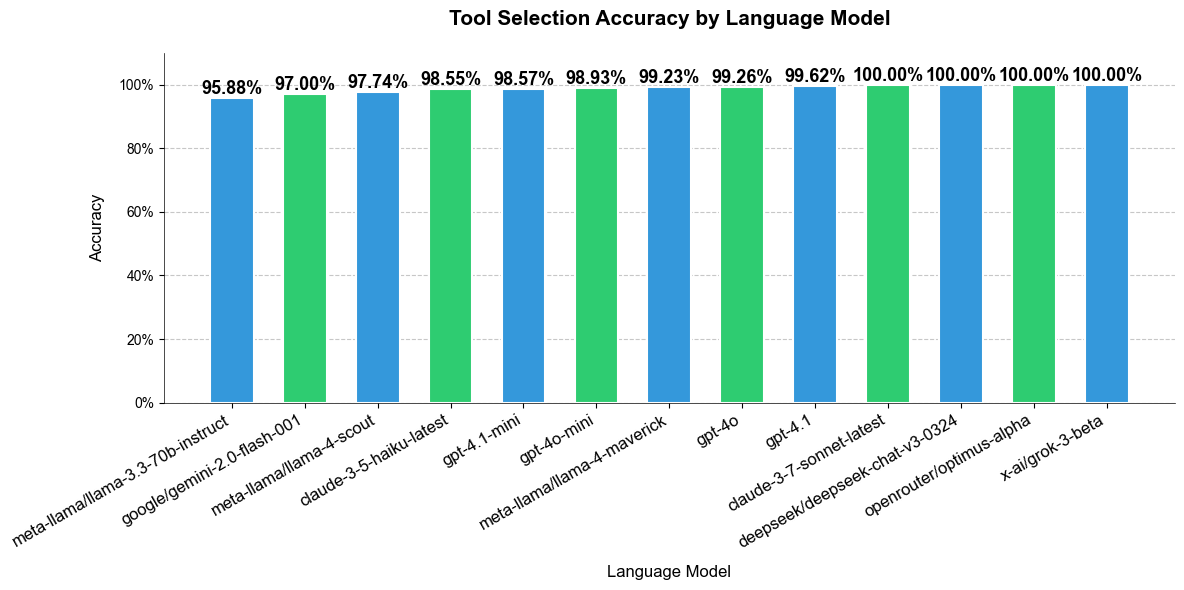

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Set the style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate mean accuracy
mean_accuracy = results_df.groupby('llm')['tool_correct'].mean().sort_values()

# Custom colors with higher saturation
colors = ['#3498db', '#2ecc71']  # Vibrant blue and green

# Create bars
bars = ax.bar(
    mean_accuracy.index,
    mean_accuracy.values,
    color=colors,
    width=0.6,
    edgecolor='white',
    linewidth=1.5
)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height,
        f'{height:.2%}',
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight='bold'
    )

# Customize the plot
ax.set_title('Tool Selection Accuracy by Language Model', 
             pad=20, 
             fontsize=15, 
             fontweight='bold')
ax.set_xlabel('Language Model', fontsize=12, labelpad=10)
ax.set_ylabel('Accuracy', fontsize=12, labelpad=10)

# Customize grid
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)  # Place gridlines behind bars

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

# Set y-axis limits with some padding
ax.set_ylim(0, min(1.1, max(mean_accuracy.values) * 1.15))

# Format y-axis as percentage
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
# Rotate x-axis labels
ax.set_xticklabels(mean_accuracy.index, rotation=30, ha='right', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig('tool_acc.png', dpi=1000)

In [130]:
mcp_tool_order

['firecrawl_tool',
 'crypto_and_nft_tool',
 'serp_tool',
 'google_spreadsheet_tool',
 'python_repl_tool']

In [131]:
# Group by LLM and tool
grouped = results_df.groupby(['llm', 'expected_tool'])

# Compute TP, FP, FN
metrics = []
metrics = []

for llm in results_df['llm'].unique():
    for tool in results_df['expected_tool'].unique():
        df_llm = results_df[results_df['llm'] == llm]

        tp = ((df_llm['first_tool_used_by_agent'] == tool) & (df_llm['expected_tool'] == tool)).sum()
        fp = ((df_llm['first_tool_used_by_agent'] == tool) & (df_llm['expected_tool'] != tool)).sum()
        fn = ((df_llm['first_tool_used_by_agent'] != tool) & (df_llm['expected_tool'] == tool)).sum()

        precision = tp / (tp + fp) if (tp + fp) else 0
        recall = tp / (tp + fn) if (tp + fn) else 0

        metrics.append({
            'llm': llm,
            'tool': tool,
            'precision': precision,
            'recall': recall
        })


metrics_df = pd.DataFrame(metrics)
metrics_df

,llm,tool,precision,recall
0,gpt-4o-mini,crypto_and_nft_tool,0.909091,1.000000
1,gpt-4o-mini,google_spreadsheet_tool,1.000000,1.000000
2,gpt-4o-mini,firecrawl_tool,1.000000,1.000000
3,gpt-4o-mini,serp_tool,1.000000,0.966667
4,gpt-4o-mini,python_repl_tool,1.000000,1.000000
...,...,...,...,...
60,gpt-4.1-mini,crypto_and_nft_tool,0.882353,1.000000
61,gpt-4.1-mini,google_spreadsheet_tool,1.000000,1.000000
62,gpt-4.1-mini,firecrawl_tool,1.000000,1.000000
63,gpt-4.1-mini,serp_tool,1.000000,0.955556


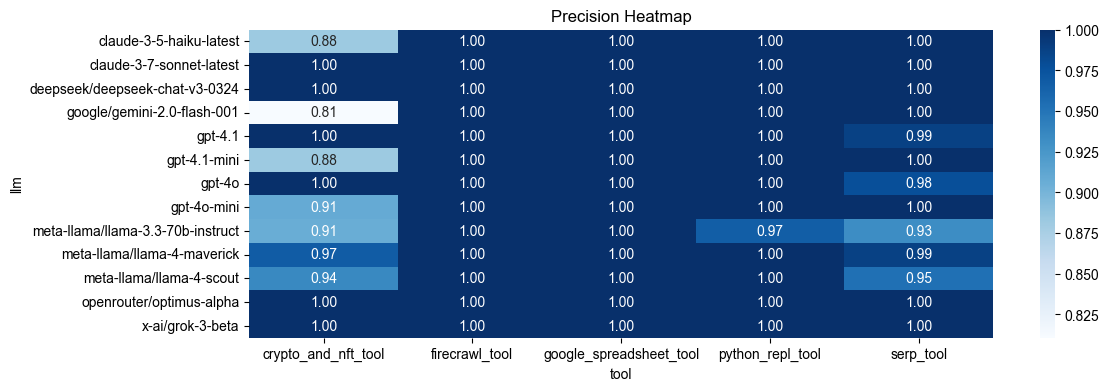

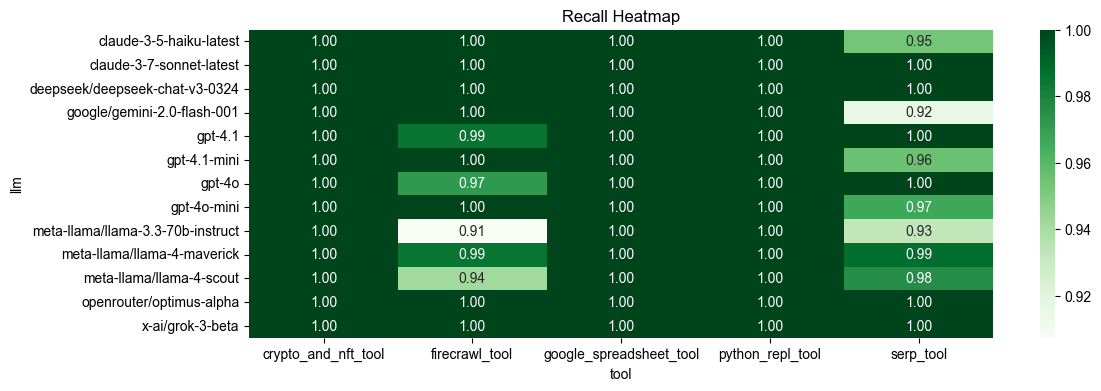

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_precision = metrics_df.pivot(index='llm', columns='tool', values='precision')
pivot_recall = metrics_df.pivot(index='llm', columns='tool', values='recall')

plt.figure(figsize=(12, 4))
sns.heatmap(pivot_precision, annot=True, fmt=".2f", cmap="Blues")
plt.title("Precision Heatmap")
plt.show()

plt.figure(figsize=(12, 4))
sns.heatmap(pivot_recall, annot=True, fmt=".2f", cmap="Greens")
plt.title("Recall Heatmap")
plt.show()


In [133]:
results_df[
    (results_df['expected_tool'] == 'google_spreadsheet_tool') & 
    (results_df['llm'].str.contains('gemini'))
]

,llm,initial_message,first_tool_used_by_agent,tools_used_by_agent,mcp_tool_order,expected_tool,correct_tool_index,chosen_tool_index,tool_correct
3640,google/gemini-2.0-flash-001,"Add a new row and just write ""To do"" in it",google_spreadsheet_tool,"[(google_spreadsheet_tool, {""action"":""append_t...","[google_spreadsheet_tool, serp_tool, python_re...",google_spreadsheet_tool,0,0.0,True
3654,google/gemini-2.0-flash-001,"Add this data to the spreadsheet: ""1, 2, 3""",google_spreadsheet_tool,"[(google_spreadsheet_tool, {""kwargs"":""{\""data\...","[serp_tool, crypto_and_nft_tool, google_spread...",google_spreadsheet_tool,2,2.0,True
3671,google/gemini-2.0-flash-001,"Add: ""Sinan, LoopGenius"" to the spreadsheet",google_spreadsheet_tool,"[(google_spreadsheet_tool, {""action"":""append_t...","[google_spreadsheet_tool, crypto_and_nft_tool,...",google_spreadsheet_tool,0,0.0,True
3677,google/gemini-2.0-flash-001,"Add: ""Sinan, LoopGenius"" to the spreadsheet",google_spreadsheet_tool,"[(google_spreadsheet_tool, {""kwargs"":""{\""data\...","[firecrawl_tool, google_spreadsheet_tool, serp...",google_spreadsheet_tool,1,1.0,True


In [134]:
results_df[
    (results_df['expected_tool'] == 'firecrawl_tool') & 
    (results_df['tool_correct'] == False)
]

,llm,initial_message,first_tool_used_by_agent,tools_used_by_agent,mcp_tool_order,expected_tool,correct_tool_index,chosen_tool_index,tool_correct
731,meta-llama/llama-3.3-70b-instruct,Go to https://loopgenius.com and tell me about it,serp_tool,"[(serp_tool, {""query"": ""https://loopgenius.com...","[python_repl_tool, serp_tool, crypto_and_nft_t...",firecrawl_tool,4,1.0,False
843,meta-llama/llama-3.3-70b-instruct,Visit https://github.com/trending and list top...,serp_tool,"[(serp_tool, {""query"": ""https://github.com/tre...","[crypto_and_nft_tool, python_repl_tool, google...",firecrawl_tool,4,3.0,False
848,meta-llama/llama-3.3-70b-instruct,Visit https://github.com/trending and list top...,serp_tool,"[(serp_tool, {""query"": ""GitHub trending reposi...","[google_spreadsheet_tool, firecrawl_tool, pyth...",firecrawl_tool,1,4.0,False
1155,meta-llama/llama-4-maverick,Check the documentation at https://pytorch.org...,serp_tool,"[(serp_tool, {""query"":""PyTorch latest version""})]","[serp_tool, python_repl_tool, firecrawl_tool, ...",firecrawl_tool,2,0.0,False
1163,meta-llama/llama-4-scout,Check the documentation at https://pytorch.org...,serp_tool,"[(serp_tool, {""query"":""PyTorch latest version ...","[crypto_and_nft_tool, serp_tool, google_spread...",firecrawl_tool,4,1.0,False
1164,meta-llama/llama-4-scout,Check the documentation at https://pytorch.org...,serp_tool,"[(serp_tool, {""query"":""PyTorch latest version ...","[crypto_and_nft_tool, google_spreadsheet_tool,...",firecrawl_tool,4,2.0,False
1167,meta-llama/llama-4-scout,Check the documentation at https://pytorch.org...,serp_tool,"[(serp_tool, {""query"":""PyTorch latest version ...","[python_repl_tool, firecrawl_tool, google_spre...",firecrawl_tool,1,3.0,False
1168,meta-llama/llama-4-scout,Check the documentation at https://pytorch.org...,serp_tool,"[(serp_tool, {""query"":""PyTorch latest version ...","[crypto_and_nft_tool, serp_tool, google_spread...",firecrawl_tool,3,1.0,False
1173,meta-llama/llama-3.3-70b-instruct,Check the documentation at https://pytorch.org...,serp_tool,"[(serp_tool, {""query"": ""PyTorch latest version...","[python_repl_tool, serp_tool, firecrawl_tool, ...",firecrawl_tool,2,1.0,False
1179,meta-llama/llama-3.3-70b-instruct,Check the documentation at https://pytorch.org...,serp_tool,"[(serp_tool, {""query"": ""PyTorch latest version...","[firecrawl_tool, google_spreadsheet_tool, cryp...",firecrawl_tool,0,4.0,False


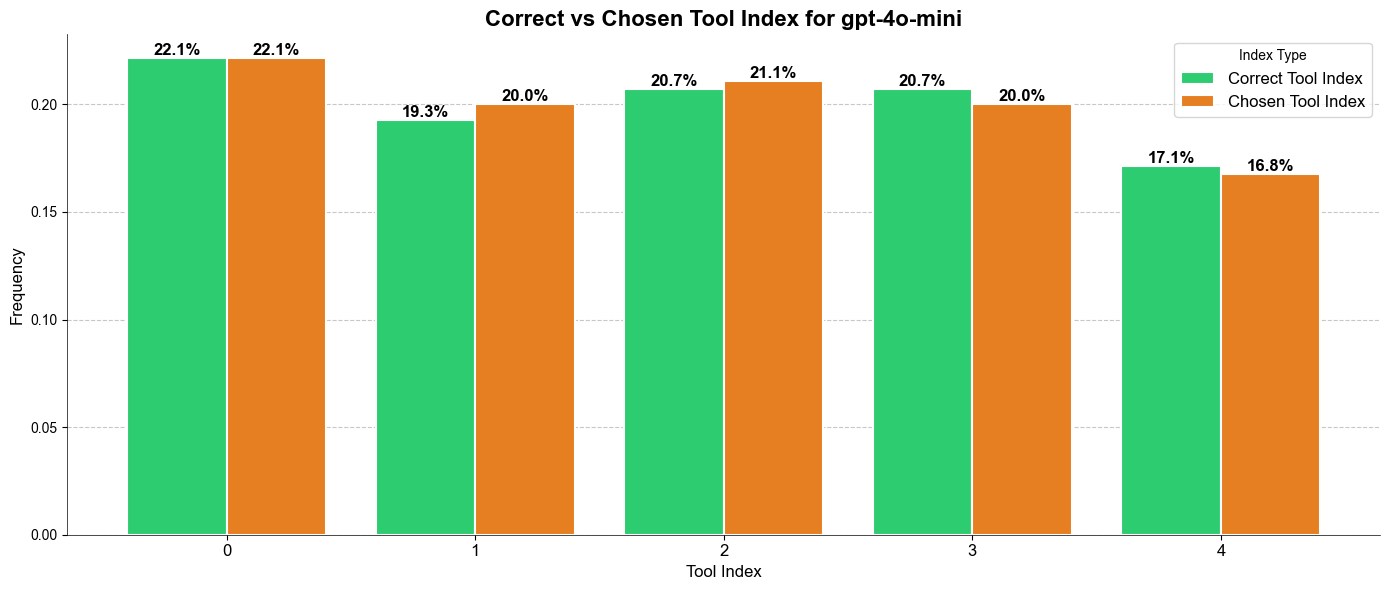

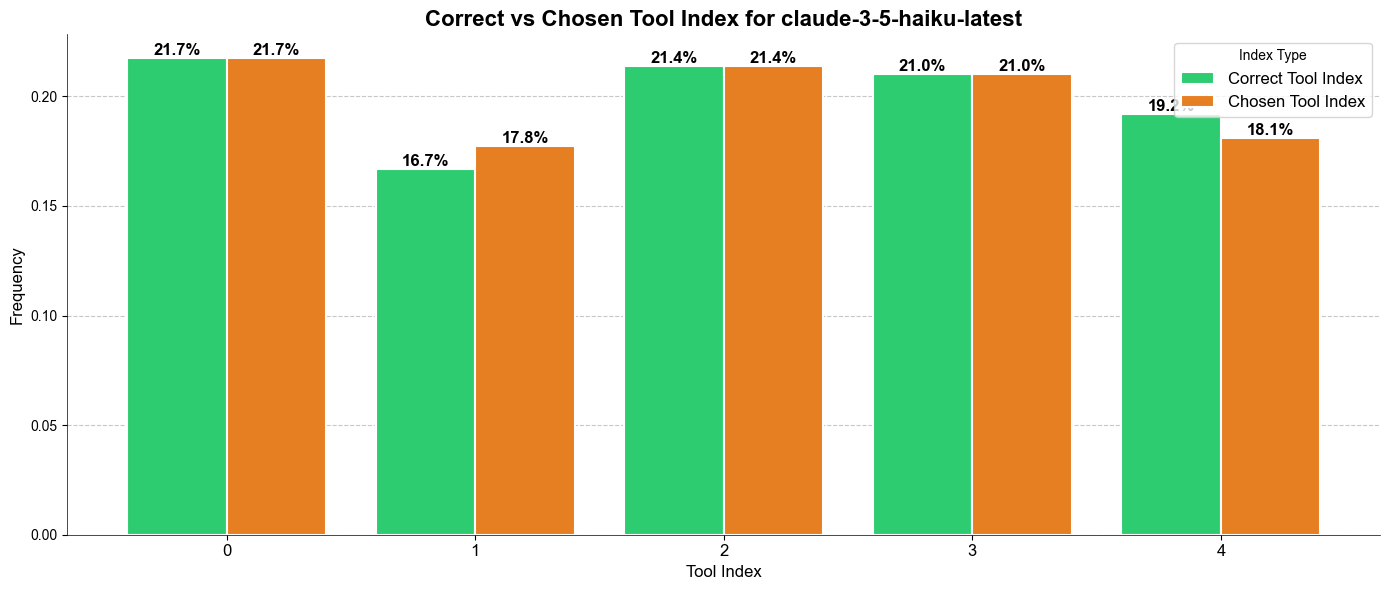

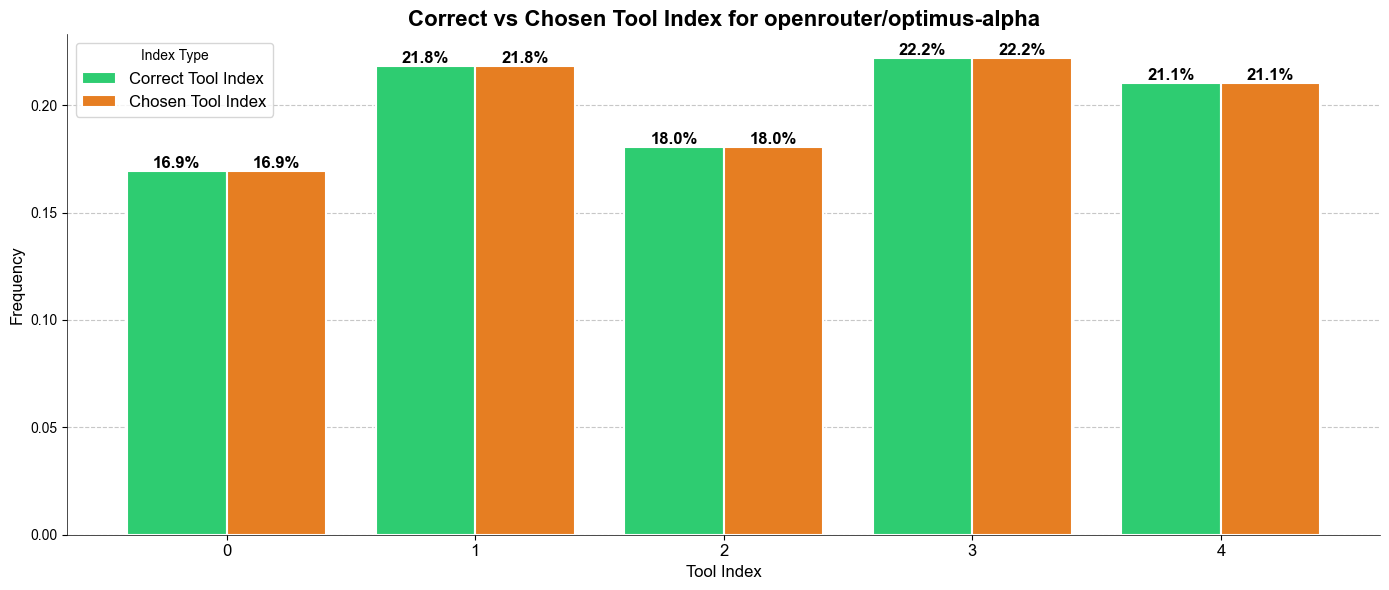

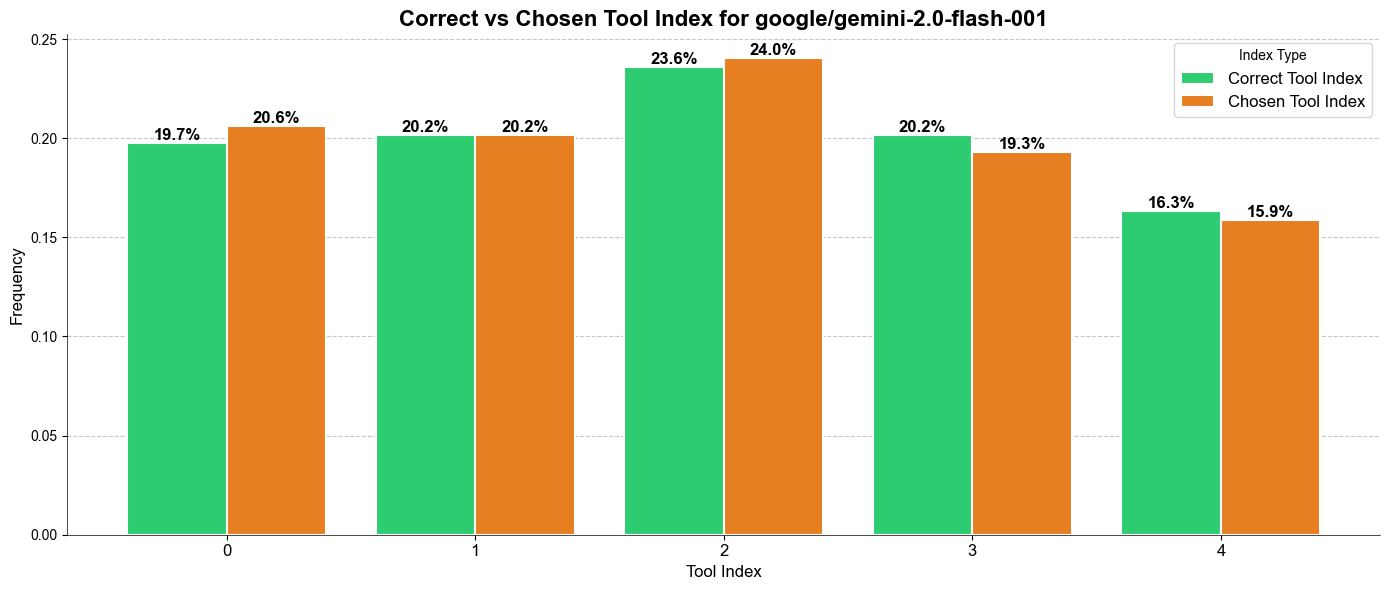

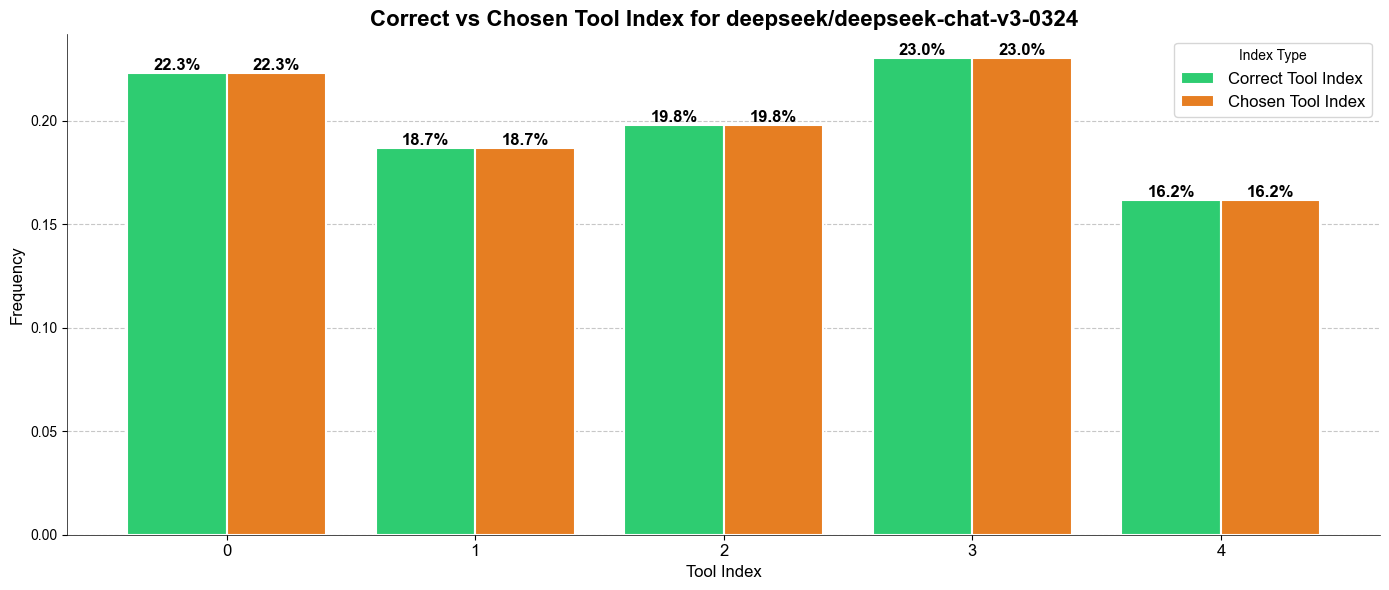

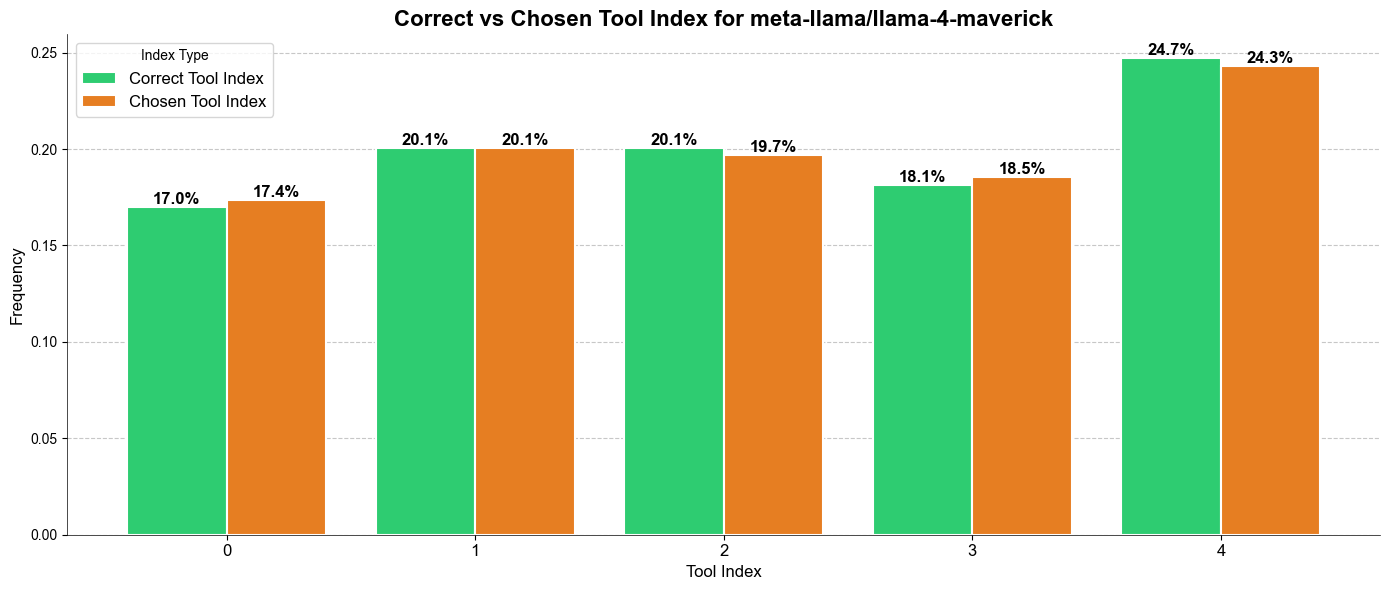

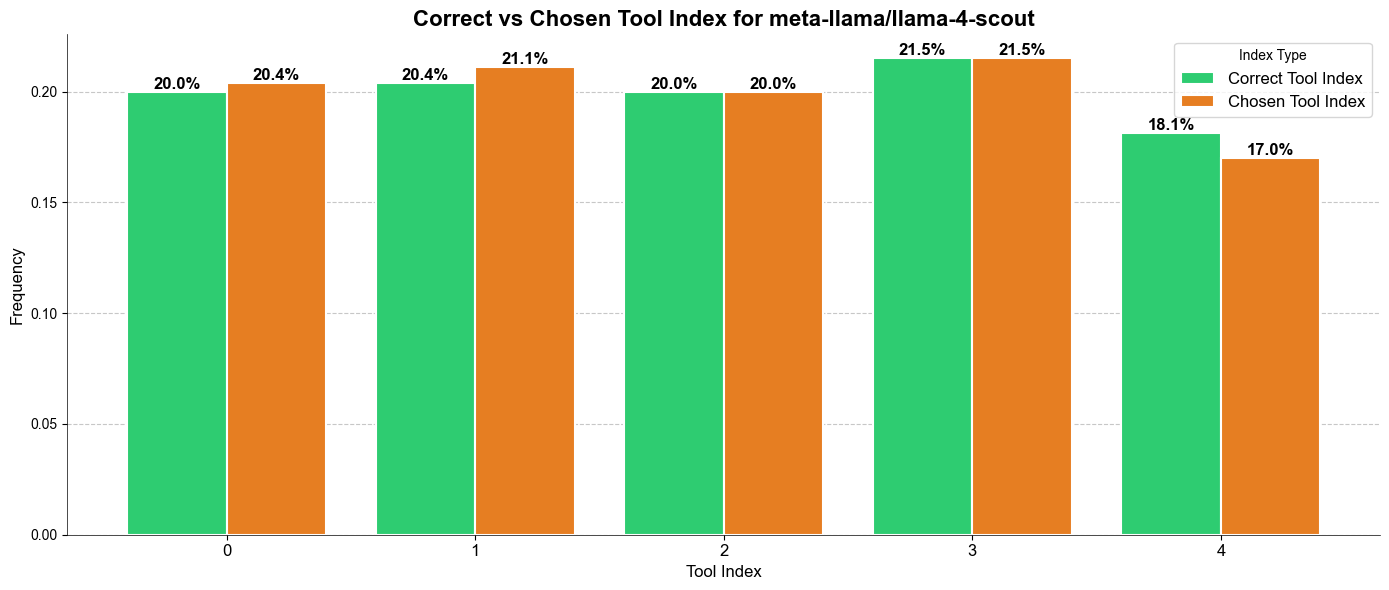

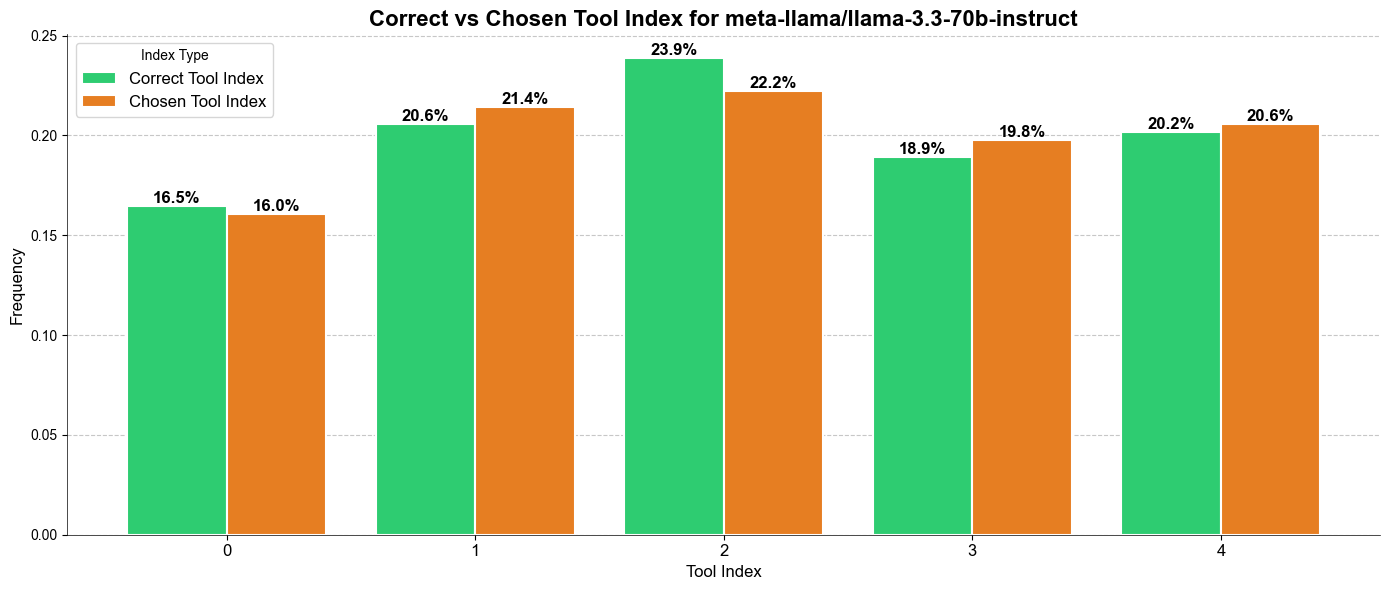

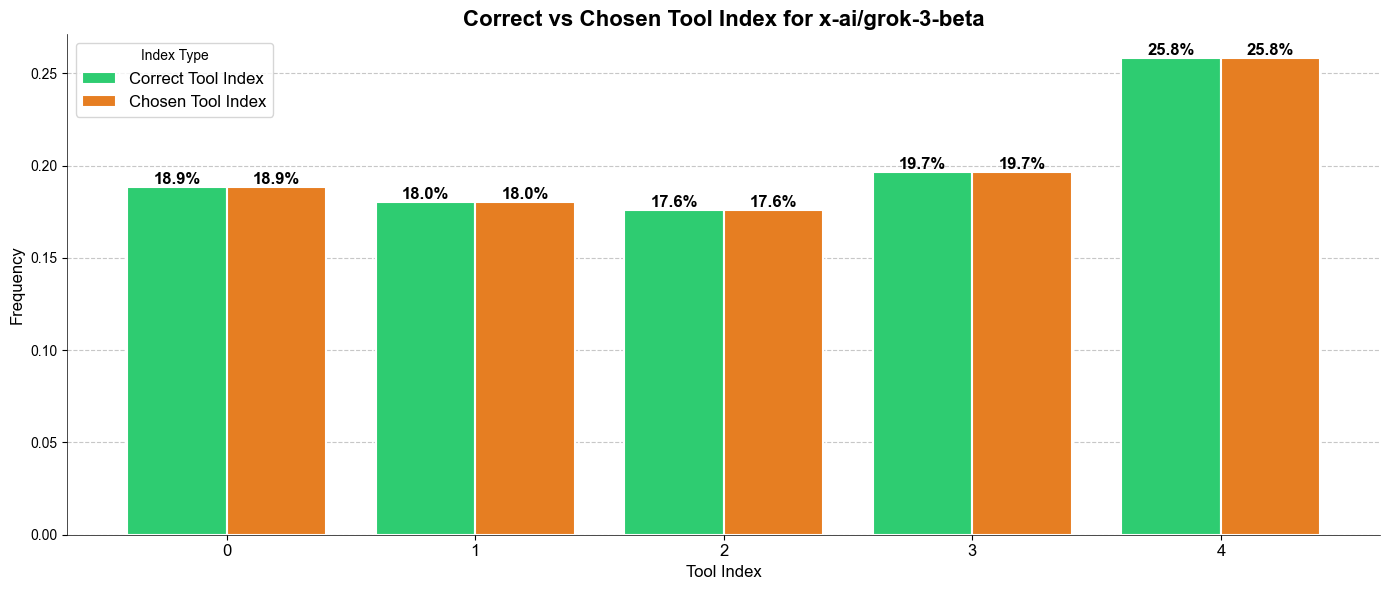

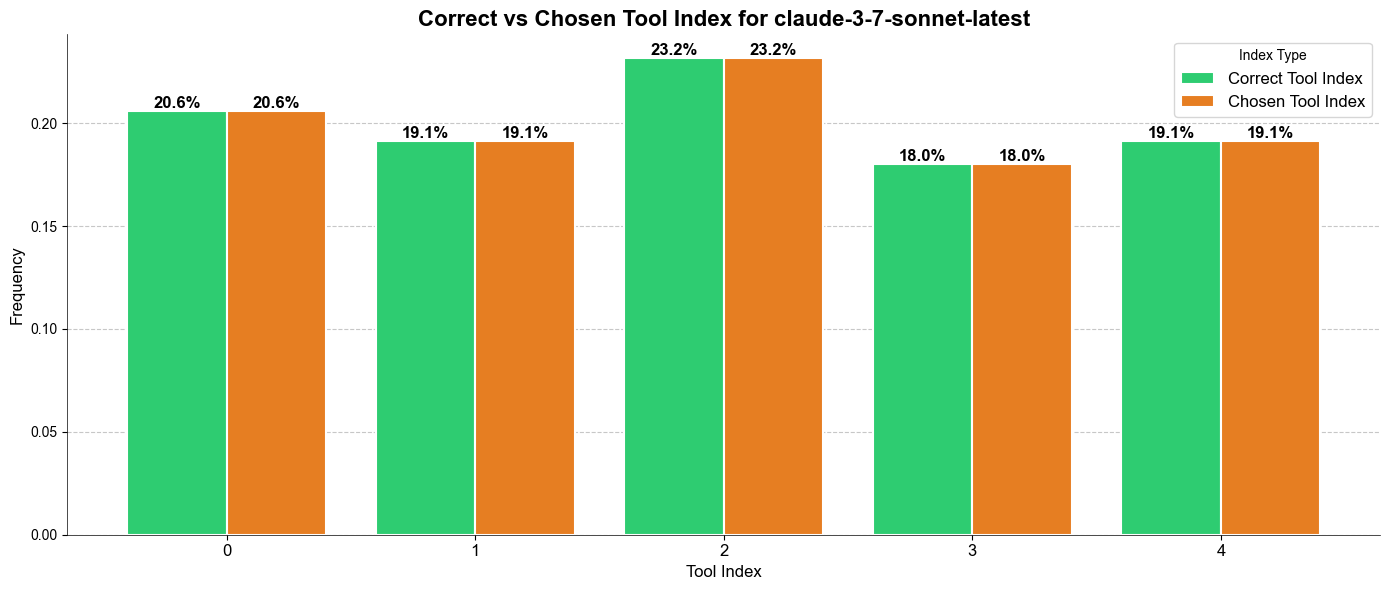

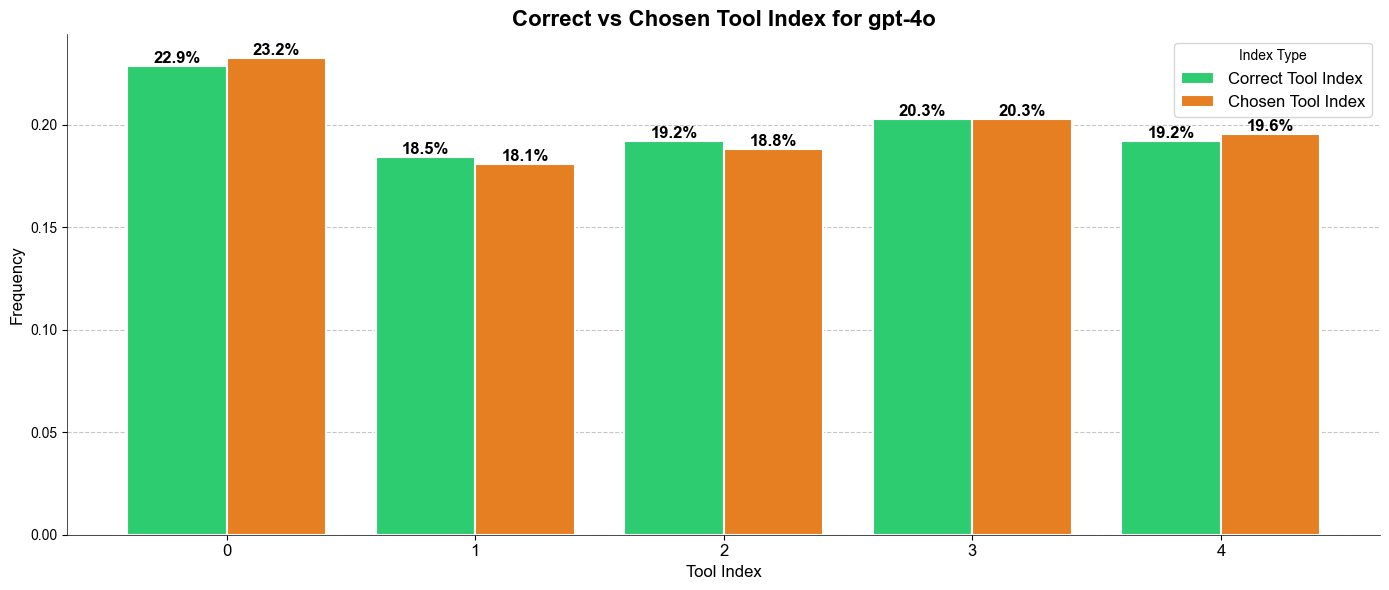

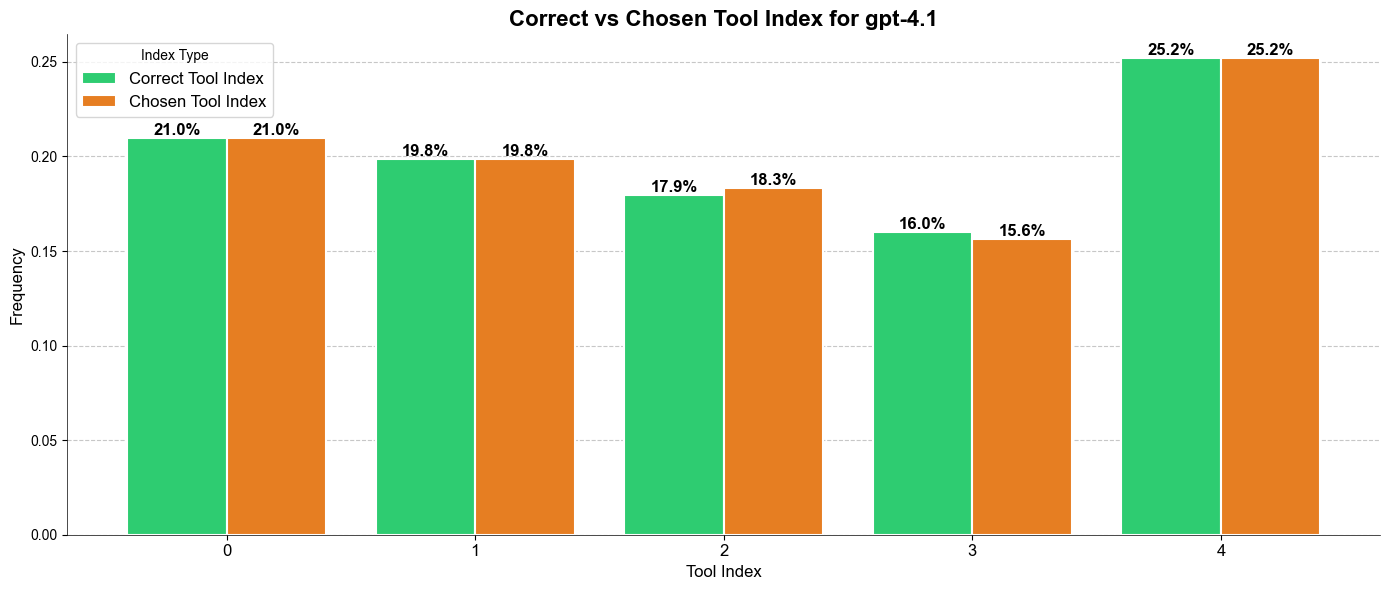

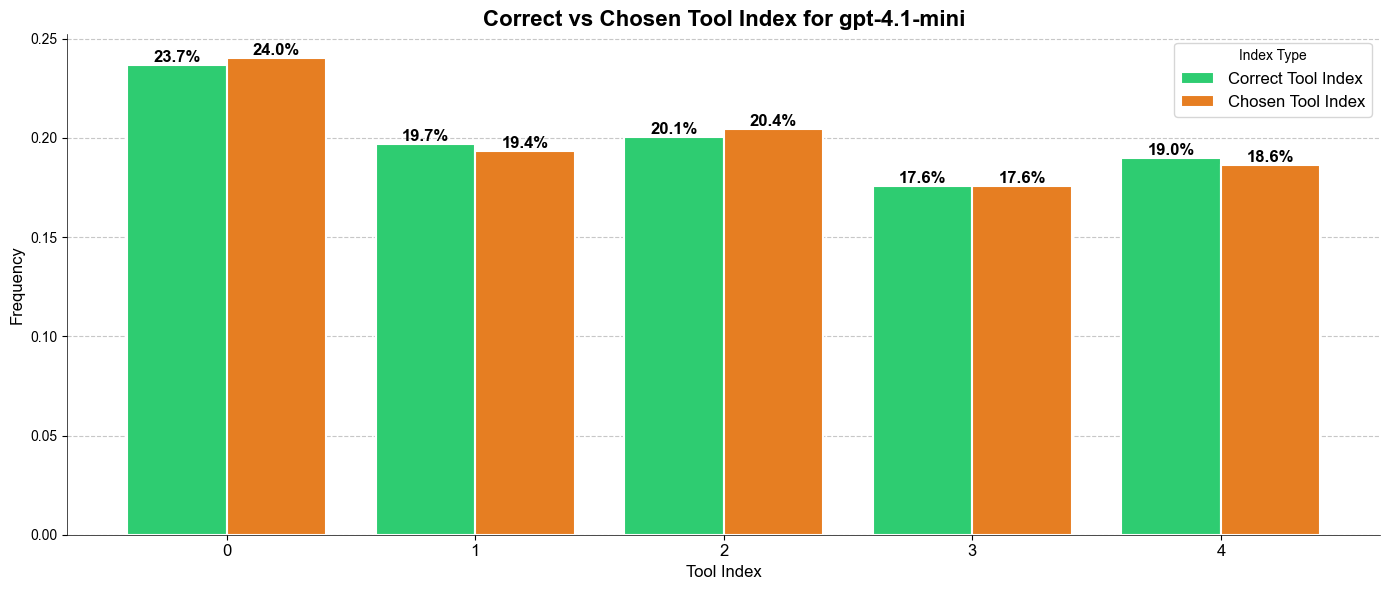

In [135]:
import matplotlib.pyplot as plt
import numpy as np

model_choices = {}

# Define the model name
for MODEL_NAME in results_df['llm'].unique():
    
    # Filter the results for the specified model
    llm_results = results_df[results_df['llm'] == MODEL_NAME].dropna()
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Define bar width and x-axis locations
    bar_width = 0.4
    x = np.arange(len(llm_results['correct_tool_index'].unique()) )
    
    # Aggregate the data for plotting
    correct_counts = llm_results['correct_tool_index'].value_counts(normalize=True).sort_index()
    chosen_counts = llm_results['chosen_tool_index'].value_counts(normalize=True).sort_index()
    
    # Align indices
    correct_counts = correct_counts.reindex(x, fill_value=0)
    chosen_counts = chosen_counts.reindex(x, fill_value=0)

    model_choices[MODEL_NAME] = ((chosen_counts - correct_counts) / correct_counts)
    
    # Plot side-by-side bars with new colors
    bars_correct = ax.bar(
        x - bar_width / 2, correct_counts, width=bar_width, color='#2ecc71', edgecolor='white', linewidth=1.5, label='Correct Tool Index'
    )
    
    bars_chosen = ax.bar(
        x + bar_width / 2, chosen_counts, width=bar_width, color='#e67e22', edgecolor='white', linewidth=1.5, label='Chosen Tool Index'
    )
    
    # Add value labels on top of each bar
    for bars in [bars_correct, bars_chosen]:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.,
                height,
                f'{round(height * 100, 1)}%',
                ha='center',
                va='bottom',
                fontsize=12,
                fontweight='bold'
            )
    
    # Customize the plot
    ax.set_title(f'Correct vs Chosen Tool Index for {MODEL_NAME}', fontsize=16, fontweight='bold')
    ax.set_xlabel('Tool Index', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(x, fontsize=12)
    
    # Customize grid and spines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Add legend
    ax.legend(title='Index Type', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


In [136]:
def plot_pos_bias(proportion_data, title):  # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define colors based on positive/negative values
    colors = ['#2ecc71' if val >= 0 else '#e74c3c' for val in proportion_data]
    
    # Plot bar chart
    bars = ax.bar(proportion_data.index, proportion_data.values, color=colors, edgecolor='white', linewidth=1.5)
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{height:.2%}',
            ha='center',
            va='bottom' if height >= 0 else 'top',
            fontsize=12,
            fontweight='bold',
            color='black'
        )
    
    # Customize the plot
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel('Correct Tool Index', fontsize=12)
    ax.set_ylabel('Average Proportion (Chosen - Correct / Correct)', fontsize=12)
    
    # Customize grid and spines
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Set y-axis limits for better visualization
    ax.set_ylim(min(proportion_data.values) - 0.05, max(proportion_data.values) + 0.05)
    
    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Adjust layout
    plt.tight_layout()
    try:
        plt.savefig(f'pos_bias_tool_{title}.png', dpi=1000)
    except:
        pass
    plt.show()


In [137]:
model_choices

{'gpt-4o-mini': chosen_tool_index
 0    0.000000
 1    0.037037
 2    0.017241
 3   -0.034483
 4   -0.020833
 Name: proportion, dtype: float64,
 'claude-3-5-haiku-latest': chosen_tool_index
 0    0.000000
 1    0.065217
 2    0.000000
 3    0.000000
 4   -0.056604
 Name: proportion, dtype: float64,
 'openrouter/optimus-alpha': chosen_tool_index
 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 Name: proportion, dtype: float64,
 'google/gemini-2.0-flash-001': chosen_tool_index
 0    0.043478
 1    0.000000
 2    0.018182
 3   -0.042553
 4   -0.026316
 Name: proportion, dtype: float64,
 'deepseek/deepseek-chat-v3-0324': chosen_tool_index
 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 Name: proportion, dtype: float64,
 'meta-llama/llama-4-maverick': chosen_tool_index
 0    0.022727
 1    0.000000
 2   -0.019231
 3    0.021277
 4   -0.015625
 Name: proportion, dtype: float64,
 'meta-llama/llama-4-scout': chosen_tool_index
 0    0.018868
 1    0.037037
 2    0.000000
 3    0.000000
 4 

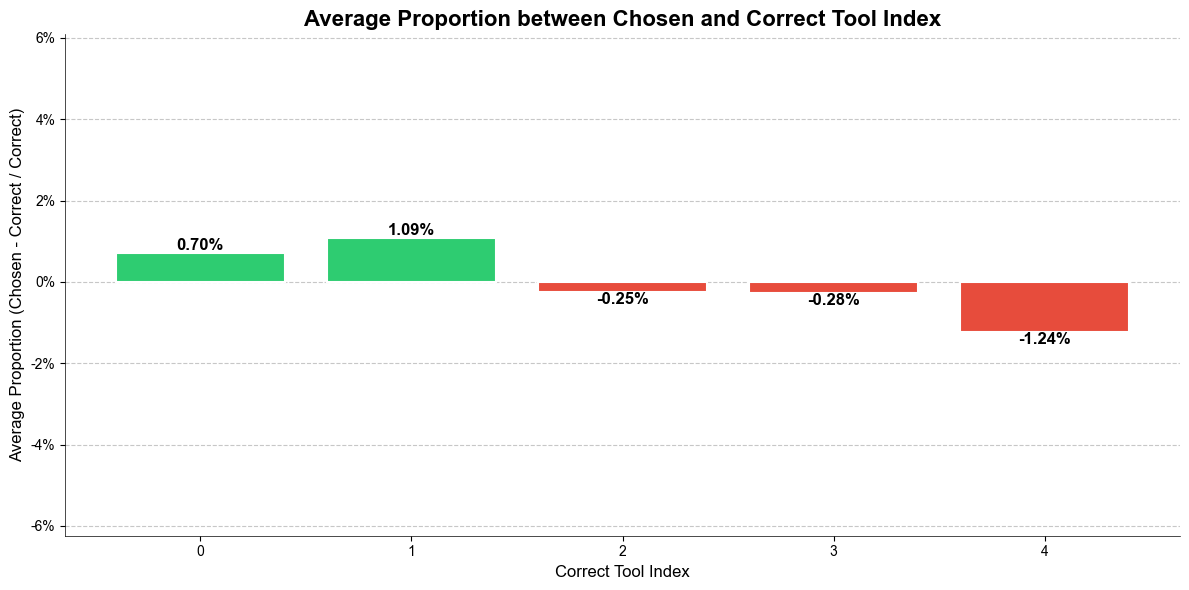

In [138]:
# Assuming model_choices is your list of Series
proportion_data = pd.concat([v for k, v in model_choices.items()], axis=1).mean(axis=1)
plot_pos_bias(proportion_data, 'Average Proportion between Chosen and Correct Tool Index')

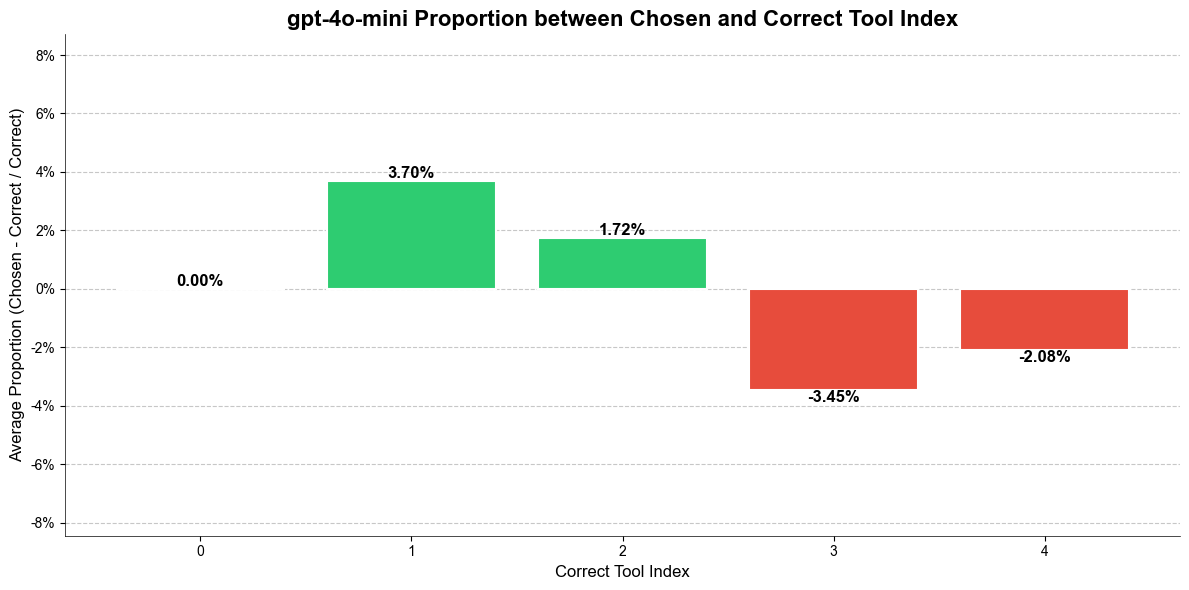

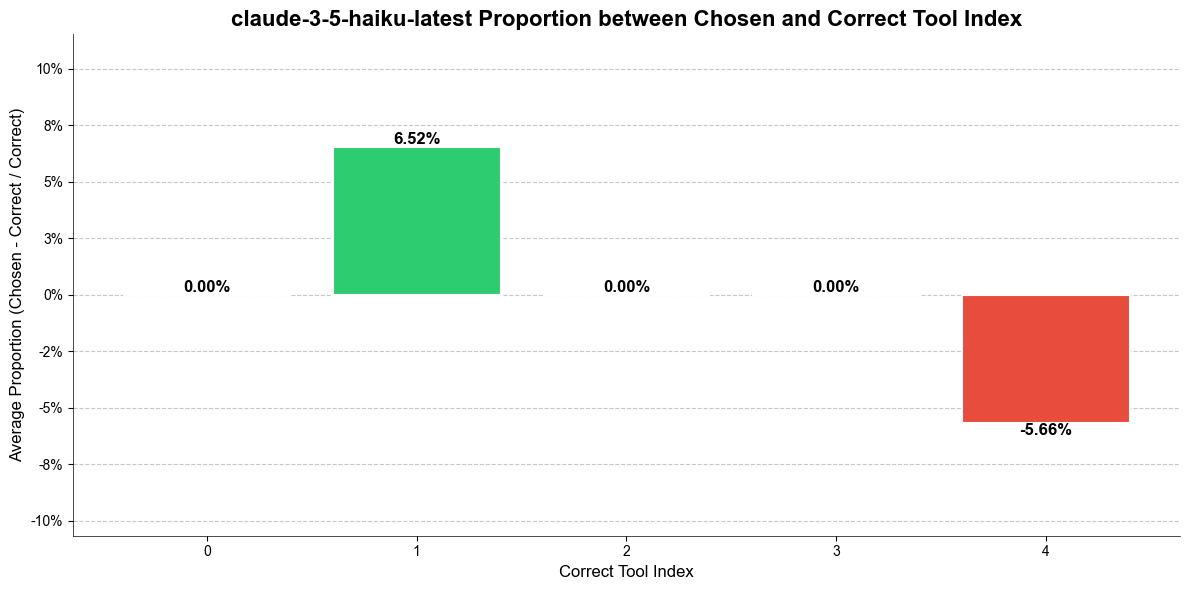

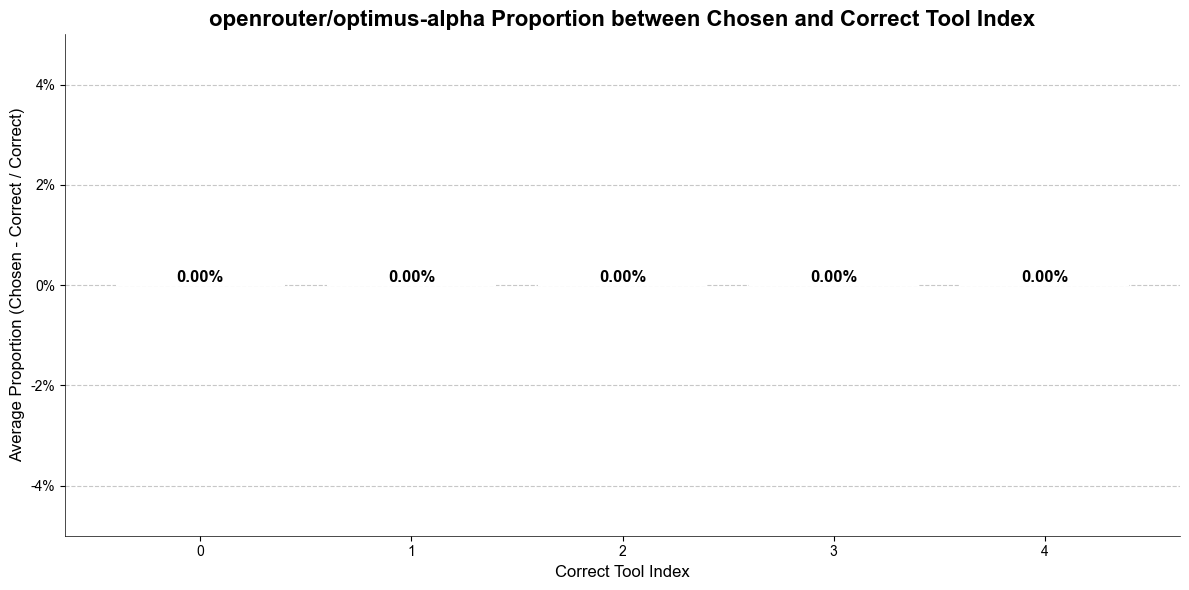

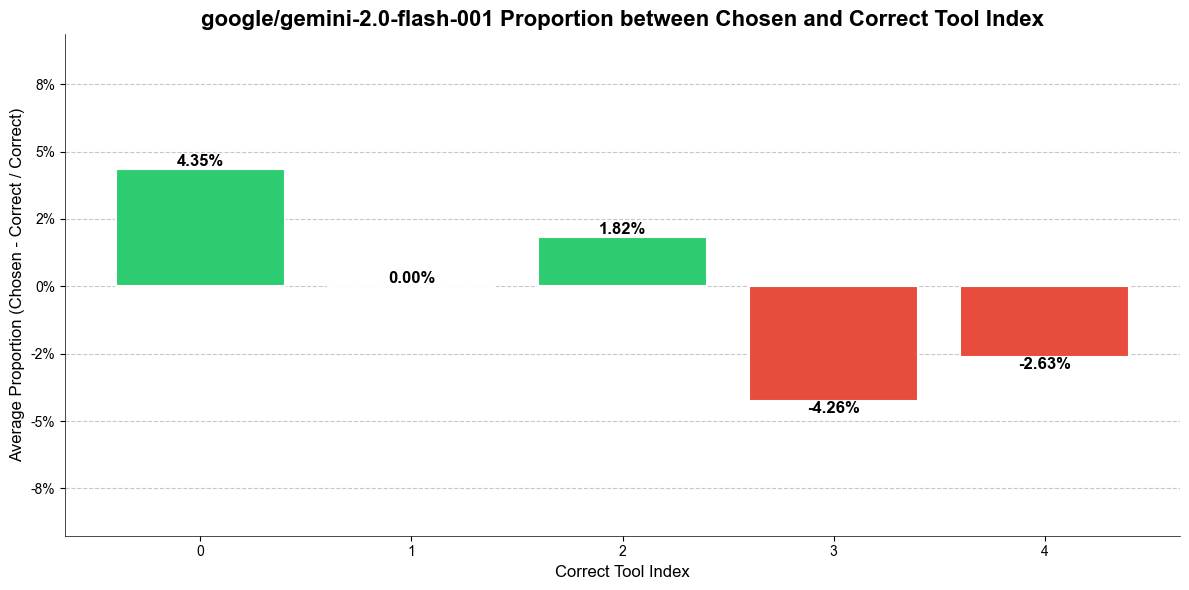

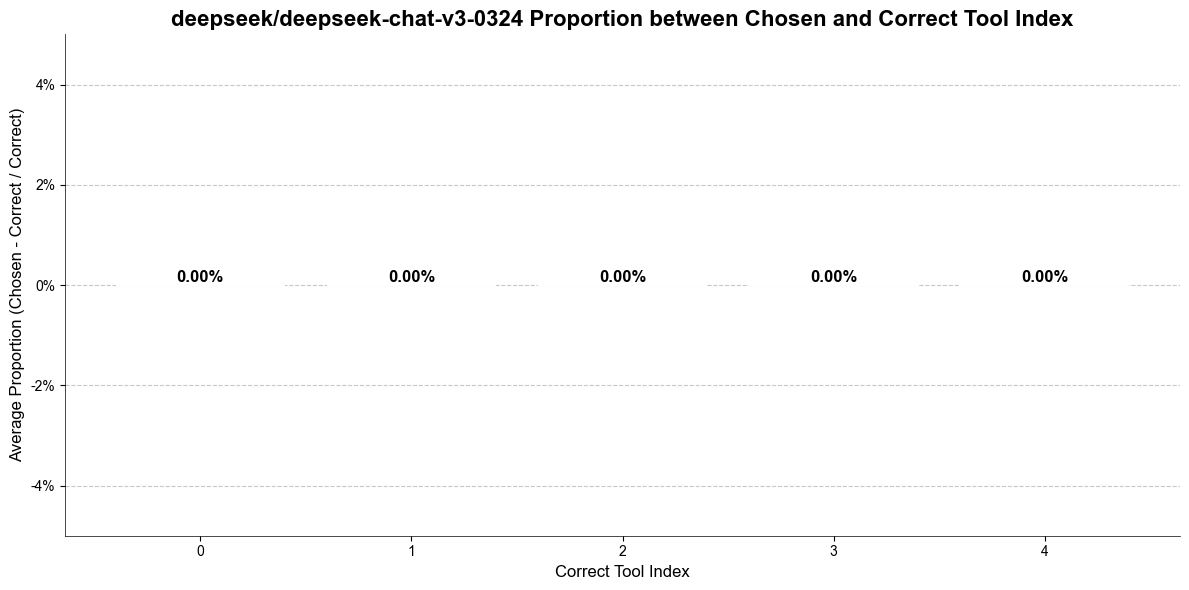

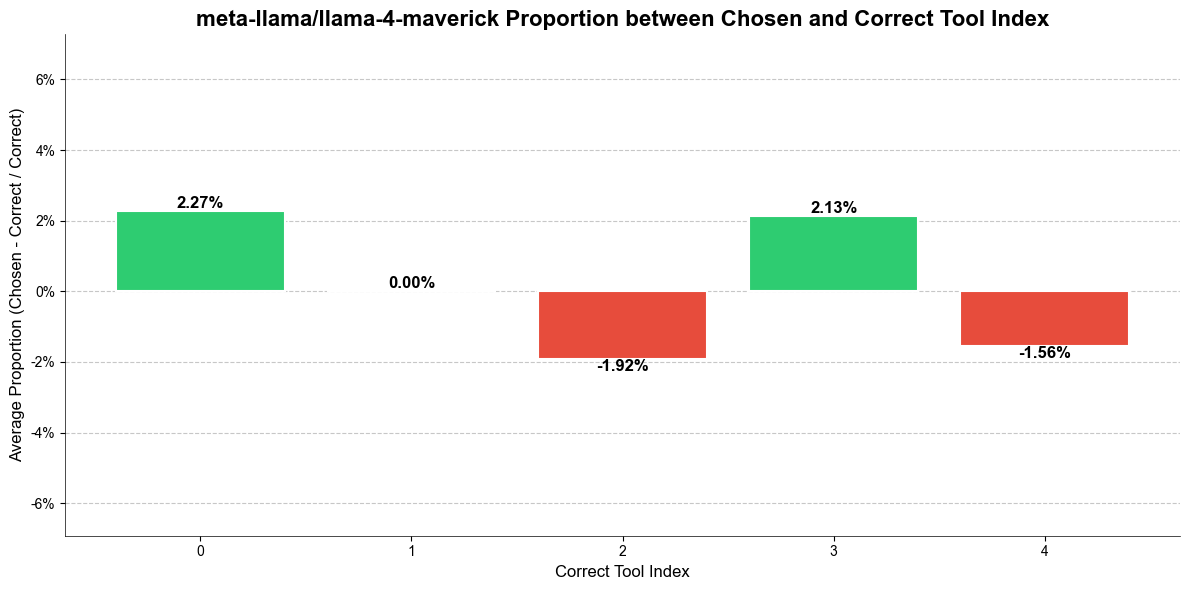

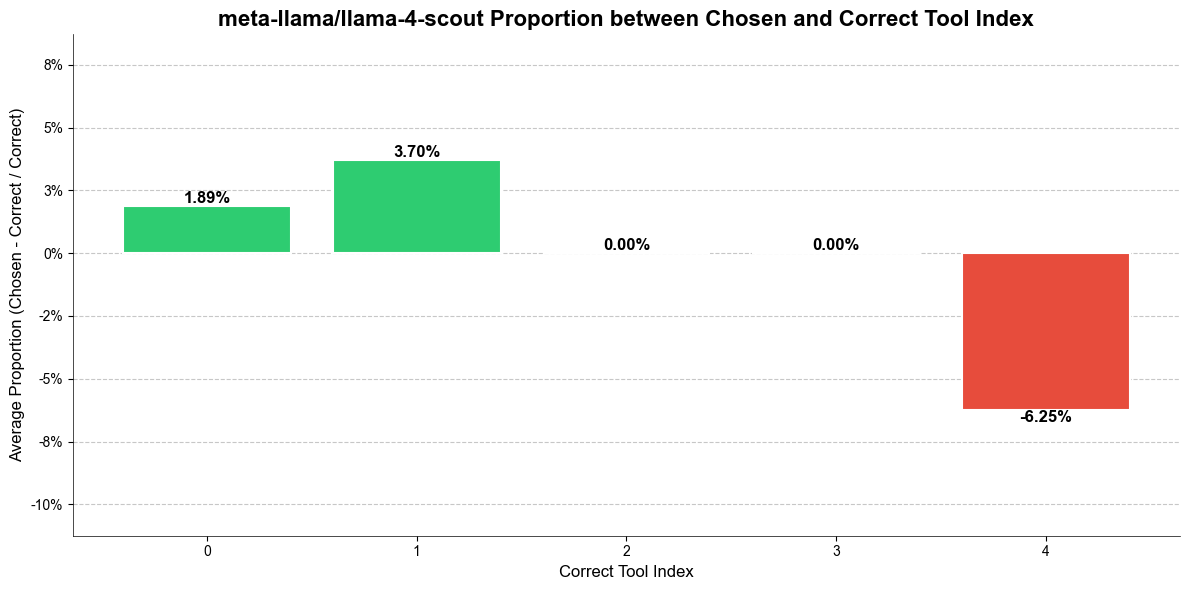

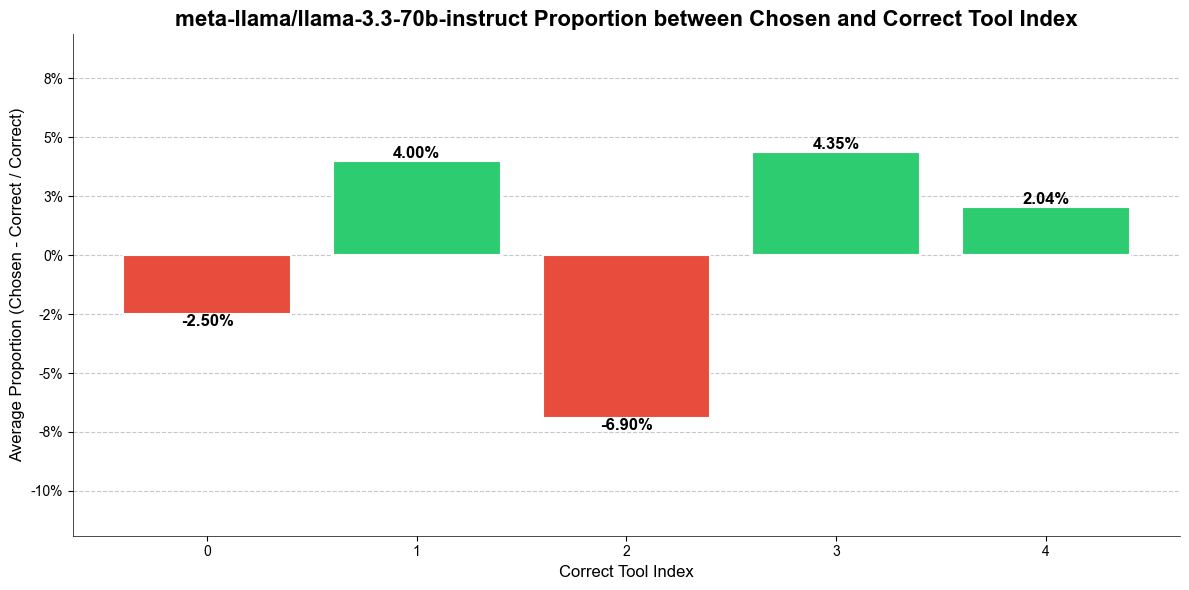

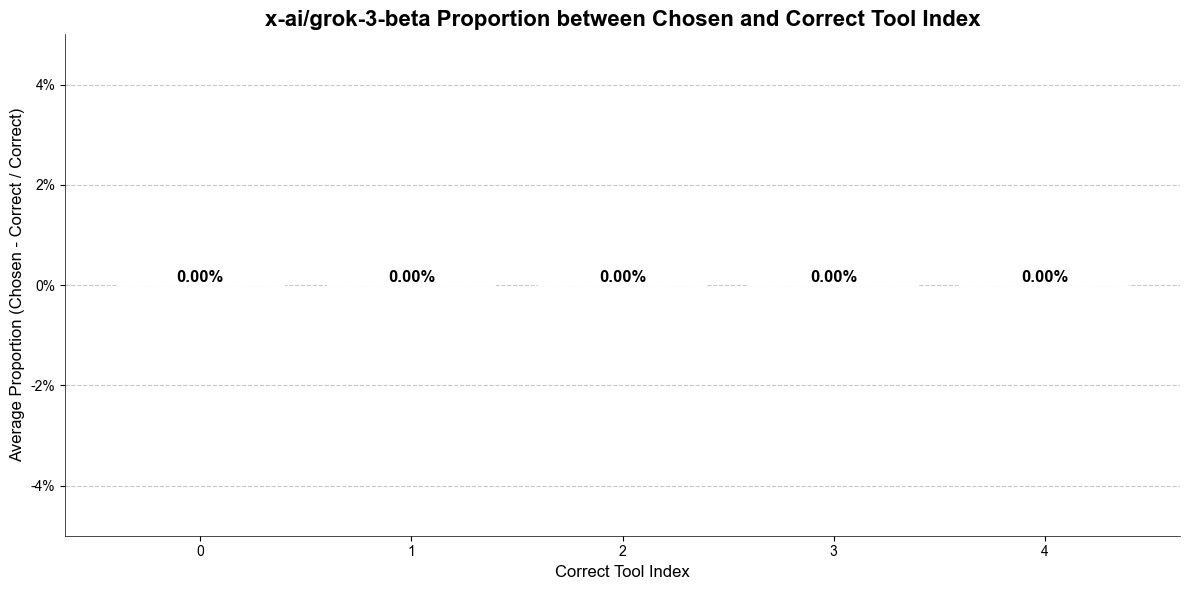

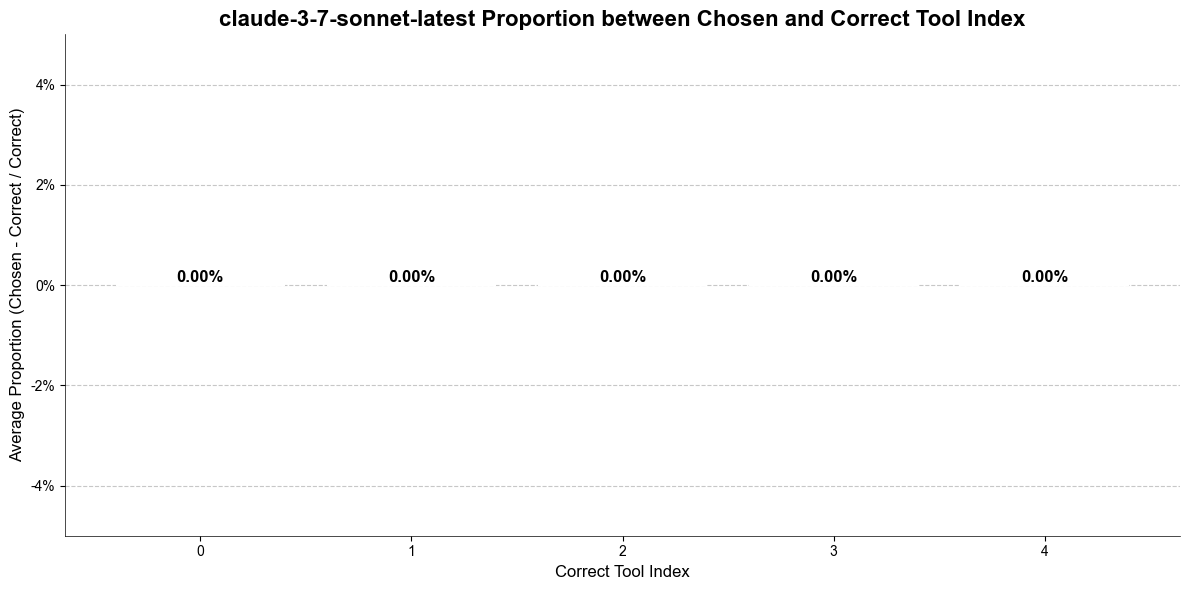

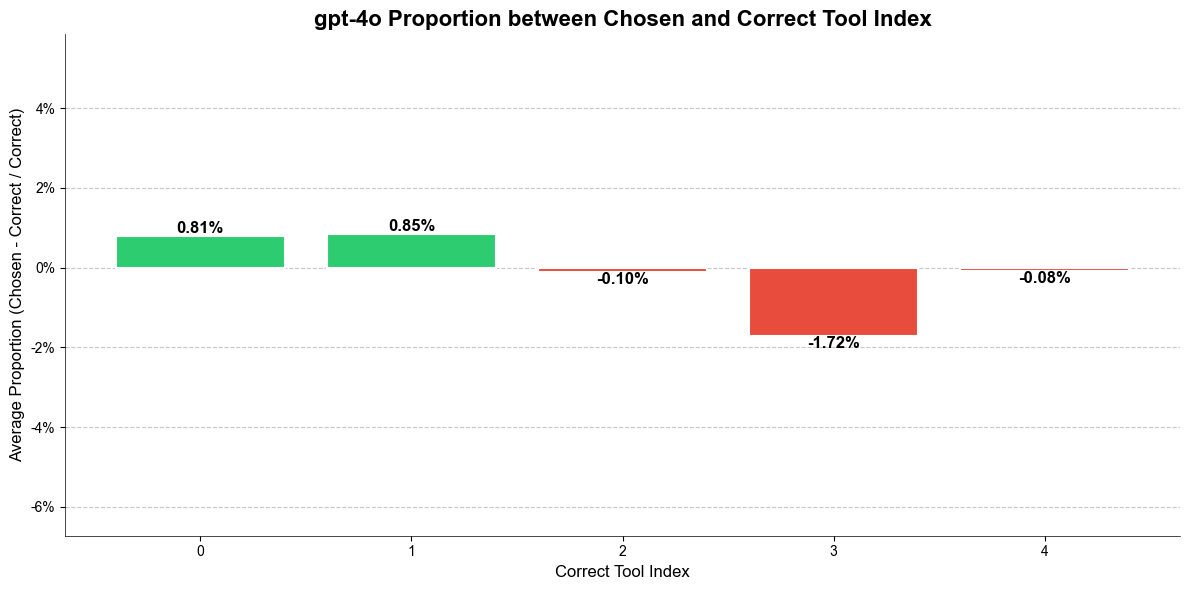

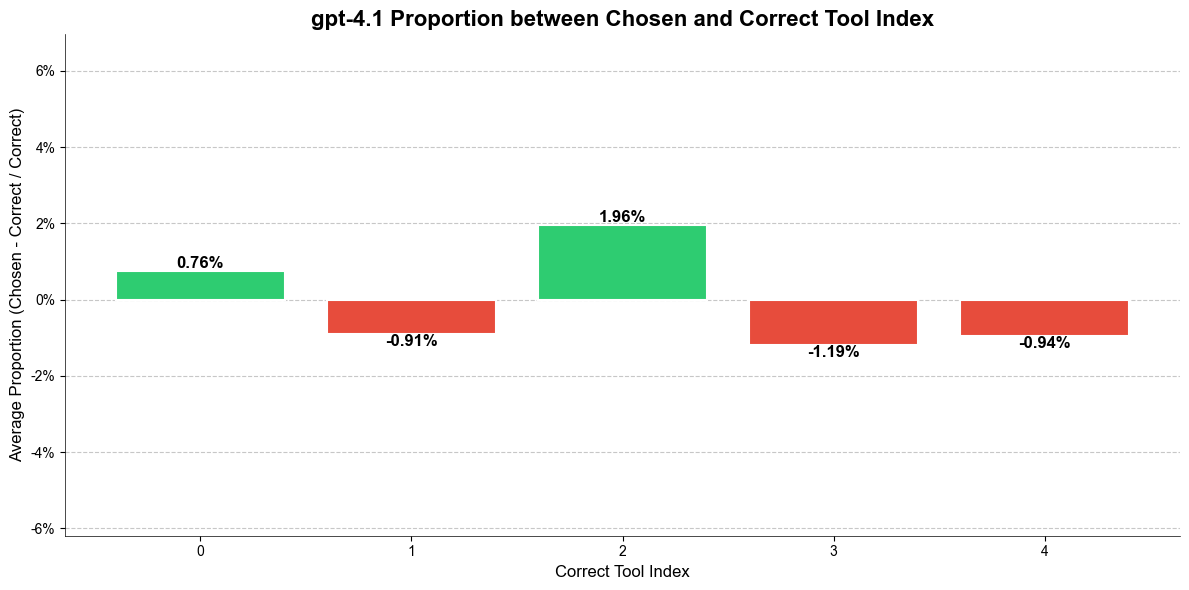

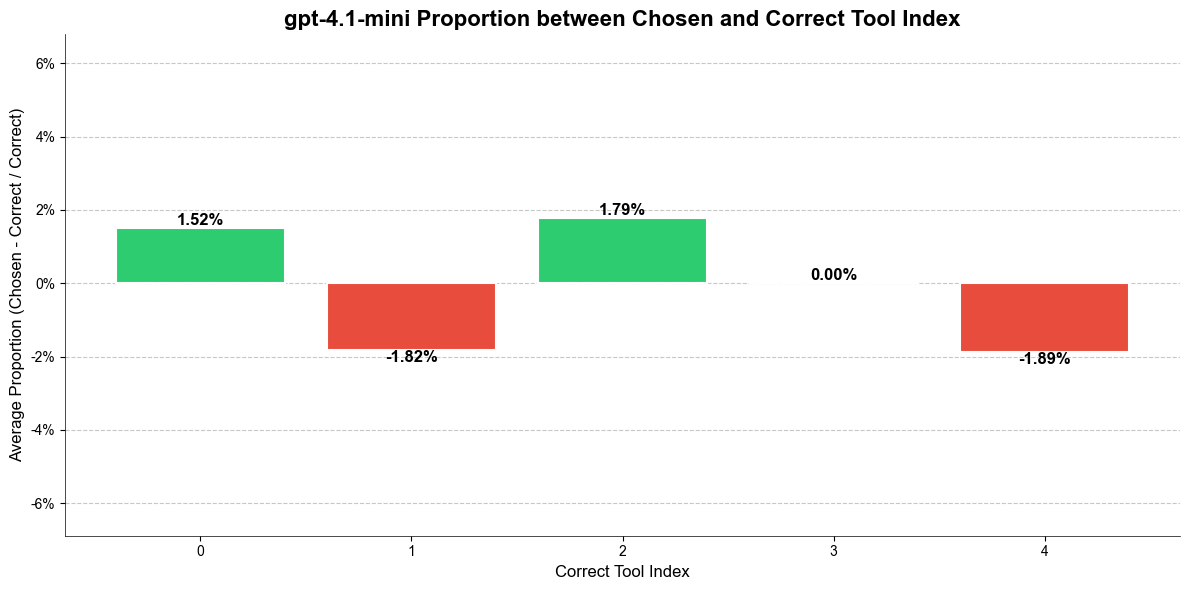

In [139]:
# Assuming model_choices is your list of Series
for model, _ in model_choices.items():
    proportion_data = pd.concat([v for k, v in model_choices.items() if model in k], axis=1).mean(axis=1)
    plot_pos_bias(proportion_data, f'{model} Proportion between Chosen and Correct Tool Index')

# Combatting Positional Bias

Sort tools in descending order of similiarty

In [13]:
import os
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

print("Loading the sentence-transformers model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
    
def sort_snippets_by_similarity(snippets, question):
    """
    Sort tool snippets by their similarity to a given question using sentence transformers.
    
    Args:
        snippets: List of text snippets to sort
        question: The question to compare against
        
    Returns:
        List of dictionaries containing the original snippets and their similarity scores,
        sorted in descending order of similarity
    """
    # Load a pre-trained sentence transformer model
    
    # Generate embeddings for the question
    question_embedding = model.encode([question])[0]
    
    # Generate embeddings for all snippets
    snippet_embeddings = model.encode(snippets)
    
    # Calculate cosine similarities
    similarities = []
    for i, (snippet, embedding) in enumerate(zip(snippets, snippet_embeddings)):
        # Calculate cosine similarity
        similarity = cosine_similarity([embedding], [question_embedding])[0][0]
        
        # Get the tool name from the snippet
        tool_name = snippet.split('def')[1].split('(')[0].strip() if 'def' in snippet else f"Unknown Tool {i}"
        
        similarities.append({
            'index': i,
            'tool_name': tool_name,
            'snippet': snippet,
            'similarity': similarity
        })
    
    # Sort by similarity in descending order
    similarities.sort(key=lambda x: x['similarity'], reverse=True)
    
    return similarities


Loading the sentence-transformers model...


In [17]:
def generate_similarity_based_mcp(question, mcp_path='similarity_based_mcp.py'):
    """
    Generate an MCP server file with tools sorted by their relevance to the given question.
    
    Args:
        question: The question to sort tools by
        mcp_path: Path where the MCP server file will be saved
        
    Returns:
        Tuple containing the absolute path of the generated file and the list of tool names in order
    """
    # Sort snippets by similarity to the question
    sorted_snippets = sort_snippets_by_similarity(tool_snippets, question)
    
    # Extract the sorted snippets
    ordered_snippets = [item['snippet'] for item in sorted_snippets]
    
    # Create full server code
    MCP_SERVER = f'''
from mcp.server.fastmcp import FastMCP
from langchain_community.tools import DuckDuckGoSearchRun
mcp = FastMCP("MCP Example")
{''.join(ordered_snippets)}
if __name__ == "__main__":
    mcp.run(transport="stdio")
    '''
    
    # Save to file
    with open(mcp_path, 'w') as f:
        f.write(MCP_SERVER)
    
    # Extract tool names for return value
    tool_names = [item['tool_name'] for item in sorted_snippets]
    
    return os.path.abspath(mcp_path), tool_names

question = "Go to loopgenius.com"

mcp_path, tool_names = generate_similarity_based_mcp(question)
print(f"\nSaved to: {mcp_path}")
print(f"Tool order: {tool_names}")



Saved to: /Users/sinanozdemir/Teaching/Pearson/oreilly-ai-agents/notebooks/similarity_based_mcp.py
Tool order: ['firecrawl_tool', 'crypto_and_nft_tool', 'python_repl_tool', 'serp_tool', 'google_spreadsheet_tool']


In [44]:
updated_llms = [
            ChatOpenAI(model="gpt-4o-mini", temperature=1)
        ]
new_results = []

In [45]:
# to suppress a warning
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [46]:
from tqdm import tqdm
from random import sample
import pandas as pd
from langchain_anthropic import ChatAnthropic
n = 10
import time

for initial_message, expected_tool in tqdm(tool_selection_test_data):
    for llm in updated_llms:
        for _ in range(n):
            try:
                response, tools_used, mcp_tool_order = await tool_use_run(llm, initial_message)
                first_tool_used_by_agent = tools_used[0][0] if tools_used else None
                time.sleep(0.3)
            except Exception as e:
                errors.append(f'error: {e} on llm: {llm}')
            new_results.append(
                {
                    'llm': llm.model_name if hasattr(llm, 'model_name') else llm.model,
                    'initial_message': initial_message,
                    'first_tool_used_by_agent': first_tool_used_by_agent,
                    'tools_used_by_agent': tools_used, 
                    'mcp_tool_order': mcp_tool_order, 
                    'expected_tool': expected_tool,
                    'correct_tool_index': mcp_tool_order.index(expected_tool),
                    'chosen_tool_index': mcp_tool_order.index(first_tool_used_by_agent) if first_tool_used_by_agent in mcp_tool_order else None
                }
            )
            if len(new_results) % 10 == 0:
                print(pd.DataFrame(new_results)['chosen_tool_index'].mean(), pd.DataFrame(new_results)['correct_tool_index'].mean())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [09:06<00:00, 19.51s/it]


In [47]:
new_results_df = pd.DataFrame(new_results)
new_results_df['tool_correct'] = new_results_df['correct_tool_index'] == new_results_df['chosen_tool_index']
new_results_df.groupby('llm')['tool_correct'].mean()

llm
gpt-4o-mini    0.992857
Name: tool_correct, dtype: float64

In [55]:
print(pd.DataFrame(new_results)['chosen_tool_index'].mean() - pd.DataFrame(new_results)['correct_tool_index'].mean())

0.0


In [56]:
new_results_df[new_results_df['tool_correct'] == False]

,llm,initial_message,first_tool_used_by_agent,tools_used_by_agent,mcp_tool_order,expected_tool,correct_tool_index,chosen_tool_index,tool_correct
190,gpt-4o-mini,Get the latest stock price for Apple (AAPL),crypto_and_nft_tool,"[(crypto_and_nft_tool, {""query"":""Apple (AAPL) ...","[google_spreadsheet_tool, firecrawl_tool, serp...",serp_tool,2,3,False
193,gpt-4o-mini,Get the latest stock price for Apple (AAPL),crypto_and_nft_tool,"[(crypto_and_nft_tool, {""query"":""AAPL stock pr...","[python_repl_tool, crypto_and_nft_tool, serp_t...",serp_tool,2,1,False
